## Disclaimer and acknowledgement

Author:  H. NIU

July 21, 2021 

The notebook was partly borrowed, adpated and function-added for needs  from https://github.com/IntelliHQ/CardiacArrestMortality_ANZICS, which holds the copyright and credits on that code. This is acknowledged the LICENSE with that repo is not copied along. I greatly appreciate the authors of that code for their efforts. 

## Import libraries

In [1]:
!python -V

Python 3.7.3


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, recall_score,f1_score
import matplotlib.pyplot as plt
import pickle
import pandas_profiling

import seaborn as sns
import graphviz

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Pandas_profiling version:', pandas_profiling.__version__)

Numpy version: 1.19.4
Pandas version: 1.1.4
Pandas_profiling version: 2.12.0


In [3]:
import sklearn as sk
sk.__version__

'1.0'

In [4]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

## 1. Import dataset

In [5]:
df = pd.read_excel(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Data\150CA_EN20210701.xlsx')

df.head()

Gender  Age_value  BMI_value  Comorbidity_diabetes  \
0  Female       46.0  23.738662                     0   
1    Male       72.0  24.341758                     0   
2    Male       56.0  24.034610                     0   
3  Female       64.0  29.048656                     0   
4    Male       68.0  28.081633                     0   

   Comorbidity_hypertension  Comorbidity_CAD  Comorbidity_pulmonary  \
0                         0                0                      0   
1                         0                0                      0   
2                         0                0                      0   
3                         0                0                      0   
4                         0                0                      0   

   Comorbidity_hepatic  Comorbidity_renal  Comorbidity_neurological  ...  \
0                    0                  0                         1  ...   
1                    0                  0                         0  ...   
2                    0                  0                         0  ...   
3                    0                  0                         0  ...   
4                    0                  0                         0  ...   

   Cause_arrest Hemorrhage_ml  Blood_transfusion_ml  Epinephrine_mg  \
0    Anesthesia             0                     0            0.00   
1       Unknown          1000                   650           25.30   
2       Surgery           150                     0            0.03   
3    Anesthesia           200                     0            0.00   
4       Surgery             0                     0            7.50   

  Atropine_mg Amiodarone_g  Ephedrine_mg Methoxamine_mg  CPR_min Died  
0         0.0         0.00           0.0            0.0     0.16    0  
1         0.0         0.30           0.0            0.0   125.00    1  
2         0.0         0.15           0.0            0.0    21.00    0  
3         0.0         0.00           0.0            0.0     0.50    0  
4         0.0         0.00           6.0            0.0   180.00    1  

[5 rows x 29 columns]

In [6]:
pd.DataFrame({"NaN":df.isna().sum(), "datatype":df.dtypes})

NaN datatype
Gender                      0   object
Age_value                   0  float64
BMI_value                   0  float64
Comorbidity_diabetes        0    int64
Comorbidity_hypertension    0    int64
Comorbidity_CAD             0    int64
Comorbidity_pulmonary       0    int64
Comorbidity_hepatic         0    int64
Comorbidity_renal           0    int64
Comorbidity_neurological    0    int64
Comorbidity_tumor           0    int64
Surgical_type               0   object
Emergency                   0    int64
Trauma                      0    int64
Anaesthetic_type            0   object
Operative_position          0   object
ASA_PS                      0    int64
Timing_arrest               0   object
Defibrillate                0    int64
Cause_arrest                0   object
Hemorrhage_ml               0    int64
Blood_transfusion_ml        0    int64
Epinephrine_mg              0  float64
Atropine_mg                 0  float64
Amiodarone_g                0  float64
Ephedrine_mg                0  float64
Methoxamine_mg              0  float64
CPR_min                     0  float64
Died                        0    int64

In [7]:
df.loc[df.Age_value <12, 'Died'].value_counts()

1    5
0    3
Name: Died, dtype: int64

In [8]:
df.loc[(df.Age_value >= 12) & (df.Age_value < 40),'Died'].value_counts()

1    17
0    17
Name: Died, dtype: int64

I would combine these 6 children (<12)  and 33 young (12-40) patients together as the children (<12) are in very small number.

In [9]:
df['Age']='<12'
#df['Age']='>=65'
df.loc[(df['Age_value'] >= 12) & (df['Age_value'] < 40), 'Age'] = '12~40'
#df.loc[(df['Age_value'] < 40), 'Age'] = '<40'
df.loc[(df['Age_value'] >= 40) & (df['Age_value'] < 65), 'Age'] = '40~65'
df.loc[(df['Age_value'] >= 65), 'Age'] = '>=65'
#df.loc[(df['Age_value'] <=5), 'Age'] = '<=5'


df['BMI']='Underweight'
df.loc[(df['BMI_value'] >= 19) & (df['BMI_value'] < 24), 'BMI'] = 'Ideal'
df.loc[(df['BMI_value'] >= 24) & (df['BMI_value'] < 28), 'BMI'] = 'Overweight'
df.loc[(df['BMI_value'] >= 28), 'BMI'] = 'Obese'

df['ASA']='I'
df.loc[(df['ASA_PS'] >= 2) & (df['ASA_PS'] < 3), 'ASA'] = 'II'
df.loc[(df['ASA_PS'] >= 3) & (df['ASA_PS'] < 4), 'ASA'] = 'III'
df.loc[(df['ASA_PS'] >= 4) & (df['ASA_PS'] < 5), 'ASA'] = 'IV'
df.loc[(df['ASA_PS'] >= 5), 'ASA'] = 'V'


#df['Hemorrhage']='0'
df['Hemorrhage'] = '<200'
df.loc[(df['Hemorrhage_ml'] >= 200) & (df['Hemorrhage_ml'] < 800), 'Hemorrhage'] = '200~800'
df.loc[(df['Hemorrhage_ml'] >= 800), 'Hemorrhage'] = '>=800'

#df['Blood_transfusion']='0'
df['Blood_transfusion'] = '<200'
df.loc[(df['Blood_transfusion_ml'] >= 200) & (df['Blood_transfusion_ml'] < 800), 'Blood_transfusion'] = '200~800'
df.loc[(df['Blood_transfusion_ml'] >= 800), 'Blood_transfusion'] = '>=800'

df['Epinephrine']='0'
df.loc[(df['Epinephrine_mg'] > 0) & (df['Epinephrine_mg'] <= 5), 'Epinephrine'] = '<=5'
df.loc[(df['Epinephrine_mg'] > 5), 'Epinephrine'] = '>5'

df['Atropine']='0'
df.loc[(df['Atropine_mg'] > 0) & (df['Atropine_mg'] <= 0.65), 'Atropine'] = '<=0.65'
df.loc[(df['Atropine_mg'] > 0.65), 'Atropine'] = '>0.65'

df['Amiodarone']='0'
#df.loc[(df['Amiodarone_g'] > 0) & (df['Amiodarone_g'] <= 0.11), 'Amiodarone'] = '<=0.11'
df.loc[(df['Amiodarone_g'] > 0), 'Amiodarone'] = '0.04~0.3'
        
df['Ephedrine']='0'
#df.loc[(df['Ephedrine_mg'] > 0) & (df['Ephedrine_mg'] <= 6), 'Ephedrine'] = '<=6'
df.loc[(df['Ephedrine_mg'] > 0), 'Ephedrine'] = '6~15'
        
df['Methoxamine']='0'
#df.loc[(df['Methoxamine_mg'] > 0) & (df['Methoxamine_mg'] <= 3), 'Methoxamine'] = '<=3'
df.loc[(df['Methoxamine_mg'] > 0), 'Methoxamine'] = '1~35'
   
#df['CPR']='0'
#df.loc[(df['CPR_min'] > 0) & (df['CPR_min'] < 30), 'CPR'] = '<=30'
df.loc[(df['CPR_min'] < 30), 'CPR'] = '<30'
df.loc[(df['CPR_min'] >= 30) & (df['CPR_min'] < 60), 'CPR'] = '30~60'
df.loc[(df['CPR_min'] >= 60), 'CPR'] = '>=60'


df2=df[["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR","Died"]]


df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Gender                    150 non-null    object
 1   Age                       150 non-null    object
 2   BMI                       150 non-null    object
 3   Comorbidity_diabetes      150 non-null    int64 
 4   Comorbidity_hypertension  150 non-null    int64 
 5   Comorbidity_CAD           150 non-null    int64 
 6   Comorbidity_pulmonary     150 non-null    int64 
 7   Comorbidity_hepatic       150 non-null    int64 
 8   Comorbidity_renal         150 non-null    int64 
 9   Comorbidity_neurological  150 non-null    int64 
 10  Comorbidity_tumor         150 non-null    int64 
 11  Surgical_type             150 non-null    object
 12  Emergency                 150 non-null    int64 
 13  Trauma                    150 non-null    int64 
 14  Anaesthetic_type          

In [10]:
df=df2

## 2. Split into trainning and test set
Before doing any EDA on the data, it is best practice to split the data into trainning and test set, and only explore on the trainning set.  

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
#Now split the data into training and test set(85-15 split)
data_train, data_test = train_test_split(df, test_size=.25,
                                         stratify=df.Gender, random_state=0)

In [13]:
#Let's check to make sure the output variable is correctly stratified across train/test sets              
#stratify=df.died_hosp, random_state=0)
pd.DataFrame({
    'original': df.Gender.value_counts() / len(df),
    'train': data_train.Gender.value_counts() / len(data_train),
    'test': data_test.Gender.value_counts() / len(data_test)})[['original', 'train', 'test']]  

original     train      test
Male        0.64  0.642857  0.631579
Female      0.36  0.357143  0.368421

In [14]:
pd.DataFrame({
    'original': df.Died.value_counts() / len(df),
    'train': data_train.Died.value_counts() / len(data_train),
    'test': data_test.Died.value_counts() / len(data_test)})[['original', 'train', 'test']]         

original     train      test
1  0.546667  0.553571  0.526316
0  0.453333  0.446429  0.473684

In [15]:
pd.DataFrame({
    'original': df.Age.value_counts() / len(df),
    'train': data_train.Age.value_counts() / len(data_train),
    'test': data_test.Age.value_counts() / len(data_test)})[['original', 'train', 'test']]  

original     train      test
40~65  0.533333  0.535714  0.526316
12~40  0.226667  0.223214  0.236842
>=65   0.186667  0.187500  0.184211
<12    0.053333  0.053571  0.052632

In [16]:
len(data_train), len(data_test), len(data_test)/len(df)

(112, 38, 0.25333333333333335)

In [17]:
#So the class label is split preserving the class proportions and is in 90-10 ratio   
print(data_train.shape)
print(data_test.shape)

(112, 29)
(38, 29)


In [18]:
data_train.head()

Gender    Age         BMI  Comorbidity_diabetes  \
85     Male  40~65       Ideal                     0   
105  Female  40~65       Obese                     0   
65   Female  12~40       Ideal                     0   
142    Male  40~65       Obese                     0   
149    Male  40~65  Overweight                     0   

     Comorbidity_hypertension  Comorbidity_CAD  Comorbidity_pulmonary  \
85                          1                0                      0   
105                         0                0                      0   
65                          0                1                      0   
142                         1                1                      1   
149                         1                1                      1   

     Comorbidity_hepatic  Comorbidity_renal  Comorbidity_neurological  ...  \
85                     0                  1                         0  ...   
105                    0                  0                         0  ...   
65                     0                  0                         0  ...   
142                    0                  1                         1  ...   
149                    1                  1                         0  ...   

     Cause_arrest Hemorrhage  Blood_transfusion  Epinephrine Atropine  \
85     Anesthesia       <200               <200          <=5        0   
105       Surgery      >=800              >=800          <=5        0   
65        Unknown    200~800               <200            0        0   
142   Comorbidity      >=800              >=800          <=5    >0.65   
149   Comorbidity       <200               <200           >5        0   

    Amiodarone Ephedrine Methoxamine    CPR Died  
85           0         0           0  30~60    1  
105          0      6~15           0  30~60    1  
65           0         0           0  30~60    0  
142          0         0           0  30~60    1  
149          0         0           0  30~60    1  

[5 rows x 29 columns]

In [19]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 85 to 125
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Gender                    112 non-null    object
 1   Age                       112 non-null    object
 2   BMI                       112 non-null    object
 3   Comorbidity_diabetes      112 non-null    int64 
 4   Comorbidity_hypertension  112 non-null    int64 
 5   Comorbidity_CAD           112 non-null    int64 
 6   Comorbidity_pulmonary     112 non-null    int64 
 7   Comorbidity_hepatic       112 non-null    int64 
 8   Comorbidity_renal         112 non-null    int64 
 9   Comorbidity_neurological  112 non-null    int64 
 10  Comorbidity_tumor         112 non-null    int64 
 11  Surgical_type             112 non-null    object
 12  Emergency                 112 non-null    int64 
 13  Trauma                    112 non-null    int64 
 14  Anaesthetic_type         

## 3.1 Exploratory Data Analysis on training set

The data is analyzed by "pandas_profiling", visuaizing the exploratory analysis of the data.

**WARNING:** The code below can take **a couple of minutes** to finish

In [20]:
import pandas_profiling
pandas_profiling.ProfileReport(data_train)

Summarize dataset:   0%|          | 0/43 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Data preprocessing pipelines
Prepare the data to a format that can be fit into scikit learn algorithms

**Categorical variable encoder**

https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki
https://masongallo.github.io/machine/learning,/python/2017/10/07/machine-learning-pipelines.html

In [25]:
categorical_vars = ["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR"]

In [26]:
categorical_vars2 = ["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR","Died"]

In [27]:
data_train[categorical_vars].head()

Gender    Age         BMI  Comorbidity_diabetes  \
85     Male  40~65       Ideal                     0   
105  Female  40~65       Obese                     0   
65   Female  12~40       Ideal                     0   
142    Male  40~65       Obese                     0   
149    Male  40~65  Overweight                     0   

     Comorbidity_hypertension  Comorbidity_CAD  Comorbidity_pulmonary  \
85                          1                0                      0   
105                         0                0                      0   
65                          0                1                      0   
142                         1                1                      1   
149                         1                1                      1   

     Comorbidity_hepatic  Comorbidity_renal  Comorbidity_neurological  ...  \
85                     0                  1                         0  ...   
105                    0                  0                         0  ...   
65                     0                  0                         0  ...   
142                    0                  1                         1  ...   
149                    1                  1                         0  ...   

     Defibrillate Cause_arrest  Hemorrhage  Blood_transfusion Epinephrine  \
85              1   Anesthesia        <200               <200         <=5   
105             0      Surgery       >=800              >=800         <=5   
65              0      Unknown     200~800               <200           0   
142             1  Comorbidity       >=800              >=800         <=5   
149             0  Comorbidity        <200               <200          >5   

    Atropine Amiodarone Ephedrine  Methoxamine    CPR  
85         0          0         0            0  30~60  
105        0          0      6~15            0  30~60  
65         0          0         0            0  30~60  
142    >0.65          0         0            0  30~60  
149        0          0         0            0  30~60  

[5 rows x 28 columns]

In [28]:
# to make a custom transformer to fit into a pipeline
class Vars_selector(BaseEstimator, TransformerMixin):
    '''Returns a subset of variables in a dataframe'''
    def __init__(self, var_names):
        '''var_names is a list of categorical variables names'''
        self.var_names = var_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''returns a dataframe with selected variables'''
        return X[self.var_names]

In [29]:
class Cat_vars_encoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''X is a dataframe'''
        X['Gender'] = X.Gender.map({'Male':1, 'Female':0}) # M -> 1, F -> 0
        #X['Age'] = X.Age.map({'<40':0,'40~65':1,'>=65':2}) # 
        X['Age'] = X.Age.map({'<12':0,'12~40':1,'40~65':2,'>=65':3}) # 
        X['BMI'] = X.BMI.map({'Underweight':0, 'Ideal':1,'Overweight':2,'Obese':3}) # 
        X['ASA'] = X.ASA.map({'I':0, 'II':1, 'III':2, 'IV':3,'V':4}) # 
        X['Hemorrhage'] = X.Hemorrhage.map({'<200':0, '200~800':1,'>=800':2}) # 
        X['Blood_transfusion'] = X.Blood_transfusion.map({'<200':0, '200~800':1,'>=800':2}) # 
        X['Epinephrine'] = X.Epinephrine.map({'0':0, '<=5':1,'>5':2}) # 
        X['Atropine'] = X.Atropine.map({'0':0, '<=0.65':1,'>0.65':2}) # 
        X['Amiodarone'] = X.Amiodarone.map({'0':0, '0.04~0.3':1}) # 
        X['Ephedrine'] = X.Ephedrine.map({'0':0, '6~15':1}) # 
        X['Methoxamine'] = X.Methoxamine.map({'0':0, '1~35':1}) # 
        X['CPR'] = X.CPR.map({'<30':0,'30~60':1,'>=60':2}) # 
        X['Surgical_type'] = X.Surgical_type.map({'Abdominal':0, 'Neurosurgery':1,'Thoracic':2,'Throat':3,'Others':4}) 
        # Abdominal->0, Neurosurgery->1,Thoracic->3,Throat->4,Others->5'Orthopedics':2,
        X['Anaesthetic_type'] = X.Anaesthetic_type.map({'General':1, 'Local':0}) # General -> 1, Local -> 0
        X['Operative_position'] = X.Operative_position.map({'Left lateral decubitus':0, 'Right lateral decubitus':1,'Prone':2,
                                                           'Lithotomy':3,'Supine':4}) # 
        X['Timing_arrest'] = X.Timing_arrest.map({'Induction':0, 'Intubation':1,'Surgery':2,'NotAvaliable':3}) #
        X['Cause_arrest'] = X.Cause_arrest.map({'Anesthesia':0, 'Comorbidity':1,'Surgery':2,'Unknown':3}) # M -> 1, F -> 0
        return X.values

**Transform data in a pipeline** 

In [30]:
# categorical variables preprocessing
cat_vars_pipeline = Pipeline([
    ('selector', Vars_selector(categorical_vars)),
    ('encoder', Cat_vars_encoder())
])

In [31]:
# categorical variables preprocessing
cat_vars_pipeline2 = Pipeline([
    ('selector', Vars_selector(categorical_vars2)),
    ('encoder', Cat_vars_encoder())
])

For many machine learning algorithms, gradient descent is the preferred or even the only optimization method to learn the model parameters. Gradient descent is highly sensitive to feature scaling.

** Continuous vars **

In [32]:
continuous_vars = [] #['Age', 'BMI', 'Hemorrhage_ml', 'Blood_transfusion', 'Epinephrine_mg', 'Atropine_mg',
       #'Amiodarone_g', 'Ephedrine_mg', 'Methoxamine_mg', 'CPR_min']

In [33]:
#data_train[continuous_vars].describe()

The scales among the continuous variables vary a lot, we need to standardize them prior to modelling.

In [34]:
## continuous variables preprocessing
#cont_vars_pipeline = Pipeline([
   # ('selector', Vars_selector(continuous_vars)),
    #('standardizer', StandardScaler())
#])


To transform the two types of variables in one step

In [35]:
preproc_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline)
    #,('cont_pipeline', cont_vars_pipeline)
])

preproc_pipeline2 = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline2)
    #,('cont_pipeline', cont_vars_pipeline)
])

In [36]:
#data_train_X = pd.DataFrame(preproc_pipeline.fit_transform(data_train), 
                            #columns=categorical_vars + continuous_vars)

In [37]:
data_train_X = pd.DataFrame(preproc_pipeline.fit_transform(data_train), 
                            columns=categorical_vars + continuous_vars)

data_train_X2 = pd.DataFrame(preproc_pipeline2.fit_transform(data_train), 
                            columns=categorical_vars2 + continuous_vars)

C:\Users\neo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\neo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\neo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [38]:
data_train_X.head()

Gender  Age  BMI  Comorbidity_diabetes  Comorbidity_hypertension  \
0       1    2    1                     0                         1   
1       0    2    3                     0                         0   
2       0    1    1                     0                         0   
3       1    2    3                     0                         1   
4       1    2    2                     0                         1   

   Comorbidity_CAD  Comorbidity_pulmonary  Comorbidity_hepatic  \
0                0                      0                    0   
1                0                      0                    0   
2                1                      0                    0   
3                1                      1                    0   
4                1                      1                    1   

   Comorbidity_renal  Comorbidity_neurological  ...  Defibrillate  \
0                  1                         0  ...             1   
1                  0                         0  ...             0   
2                  0                         0  ...             0   
3                  1                         1  ...             1   
4                  1                         0  ...             0   

   Cause_arrest  Hemorrhage  Blood_transfusion  Epinephrine  Atropine  \
0             0           0                  0            1         0   
1             2           2                  2            1         0   
2             3           1                  0            0         0   
3             1           2                  2            1         2   
4             1           0                  0            2         0   

   Amiodarone  Ephedrine  Methoxamine  CPR  
0           0          0            0    1  
1           0          1            0    1  
2           0          0            0    1  
3           0          0            0    1  
4           0          0            0    1  

[5 rows x 28 columns]

## 3.2 Exploratory Data Analysis on training set

The is analyzed by "pandas_profiling", visuaizing the exploratory analysis of the data. Here, we look into the one-hot encoded features

**WARNING:** The code below can take **a couple of minutes** to finish

In [35]:
#import pandas_profiling
pandas_profiling.ProfileReport(data_train_X2)

Summarize dataset:   0%|          | 0/42 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


## 5. Fitting a classifier and fine-tuning

In [40]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, cross_val_score,cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

In [41]:
data_train['Died'].value_counts()

1    62
0    50
Name: Died, dtype: int64

This is a fairly balanced dataset(i.e., the number of positive and negative cases are roughly the same), and we'll use AUC as our metric to optimise the model performance.


**_Assessing learning curve using the model default settings_**  
Tuning the model hyper-parameters are always difficult, so a good starting point is to see how the Scikit-learn default settings for the model performs, i.e., to see if it overfits or underfits, or is just right. This will give a good indication as to the direction of tuning. 

In [42]:
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc',
                                                           random_state=0, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="training scores")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="x-val scores")
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.xlabel("Training set size")
    plt.ylabel("Area under Curve")
    plt.title('{} learning curve'.format(model.__class__.__name__))


### Logistic Regression
Our first model is logistic regression

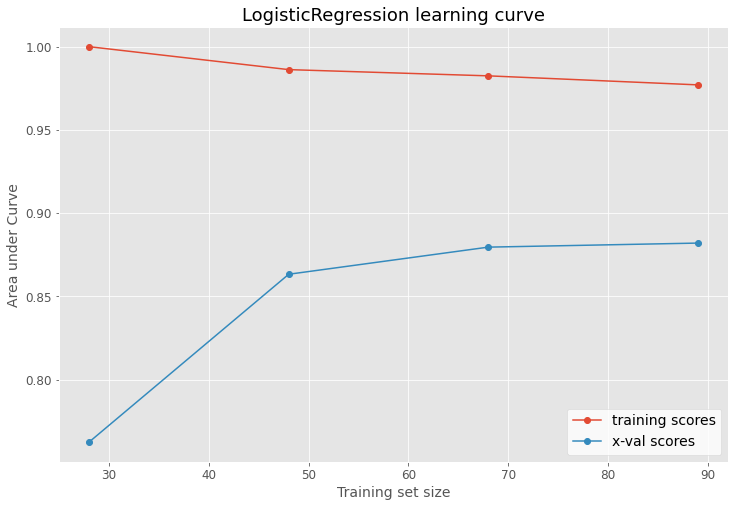

In [43]:
lr_clf = LogisticRegression(n_jobs = -1)
plot_learning_curves(lr_clf, data_train_X, data_train['Died'])

Let's see if we can squeeze some more performance out by optimising C.

In [38]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)


param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
    }
lr_clf = LogisticRegression(random_state=0)


grid_search = GridSearchCV(lr_clf, param_grid=param_grid, return_train_score=True,
                                cv=cv, scoring='roc_auc', n_jobs=-1)

grid_search.fit(data_train_X, data_train['Died'])

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
             estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc')

In [39]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores       Params
0      0.884813      0.977979     {'C': 1}
1      0.878176      0.943797   {'C': 0.1}
2      0.864383      0.992994    {'C': 10}
3      0.839626      0.889471  {'C': 0.01}
4      0.834353      0.997961   {'C': 100}
5      0.814177      0.999221  {'C': 1000}

Looks like C=1 is our best value.

In [40]:
lr_clf = grid_search.best_estimator_
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\lr_clf_final_round.pk1', 'wb') as f:
    pickle.dump(lr_clf, f)

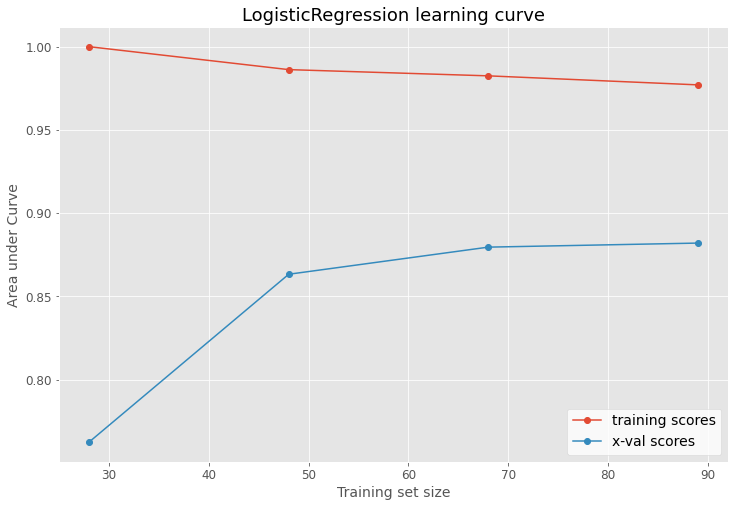

In [41]:
plot_learning_curves(lr_clf, data_train_X, data_train['Died'])

Looks like the logistic regression model would benefit from additional data.

### Random Forests classifier
Random forests classifier is an ensemble tree-based model that reduces the variance of the predictors.

_plot the learning curve to find out where the default model is at_

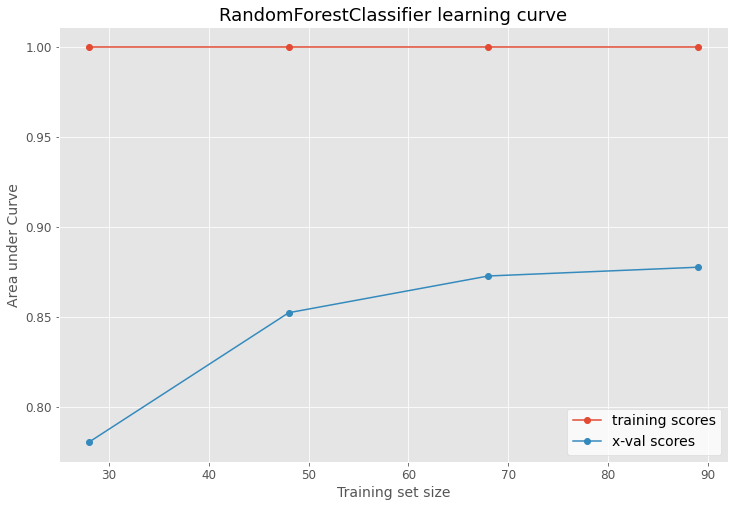

In [42]:
rf_clf = RandomForestClassifier(random_state=0)
plot_learning_curves(rf_clf, data_train_X, data_train['Died'])

The default Random Forests classifier needs to be constrained. We'll use a randomised search to optimise hyperparameters

In [43]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)

param_distribs = {
        'n_estimators': stats.randint(low=1, high=50),
         'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=2, high=100),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
    }
rf_clf = RandomForestClassifier(random_state=0)
rnd_search = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=cv, scoring='roc_auc', random_state=0, n_jobs=-1)
rnd_search.fit(data_train_X, data_train['Died'])

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
                   estimator=RandomForestClassifier(random_state=0), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A977CD79B0>,
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A976F2A6A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A976F2A4A8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A977B201D0>},
                   random_state=0, return_train_score=True, scoring='roc_auc')

In [44]:
cv_rlt = rnd_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.860810      0.984187   
1       0.831424      0.921966   
2       0.825814      0.911540   
3       0.821394      0.884893   
4       0.813528      0.910232   
..           ...           ...   
95      0.500000      0.500000   
96      0.500000      0.500000   
97      0.500000      0.500000   
98      0.500000      0.500000   
99      0.500000      0.500000   

                                               Params  
0   {'max_depth': 23, 'max_features': 'log2', 'min...  
1   {'max_depth': 38, 'max_features': 'log2', 'min...  
2   {'max_depth': 5, 'max_features': 'log2', 'min_...  
3   {'max_depth': 21, 'max_features': 'log2', 'min...  
4   {'max_depth': 19, 'max_features': 'log2', 'min...  
..                                                ...  
95  {'max_depth': 22, 'max_features': 'auto', 'min...  
96  {'max_depth': 49, 'max_features': 'auto', 'min...  
97  {'max_depth': 65, 'max_features': 'log2', 'min...  
98  {'max_depth': 62, 'max_features': 'log2', 'min...  
99  {'max_depth': 20, 'max_features': 'log2', 'min...  

[100 rows x 3 columns]

As suspected, the best parameters have set constraints on the depth of the tree, mininum samples on the split nodes and leaf nodes.

In [45]:
rf_clf = rnd_search.best_estimator_
rf_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'wb') as f:
    pickle.dump(rf_clf, f)

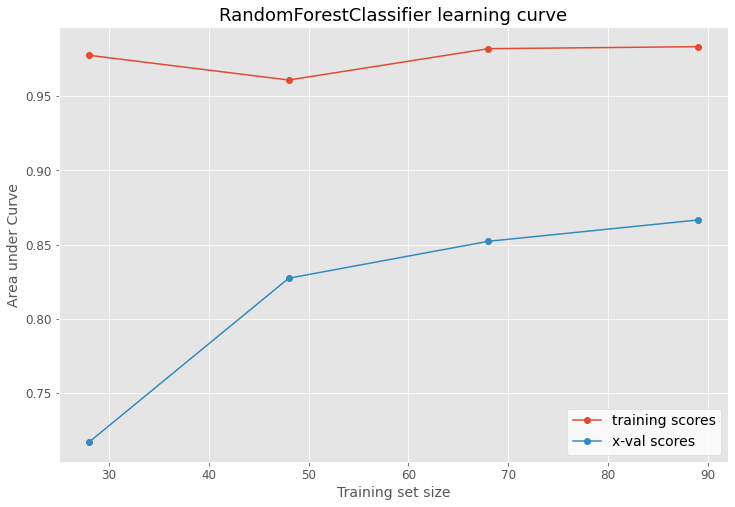

In [46]:
plot_learning_curves(rf_clf, data_train_X, data_train['Died'])

The learning curve of the best Random Forests model suggests that the performance of the model might continue to increase with more traning data.

### Gradient boosting classifier
Gradient boosting classifier is an ensemble tree-based model that reduces the bias of the predictors.

_plot the learning curve to find out where the default model is at_

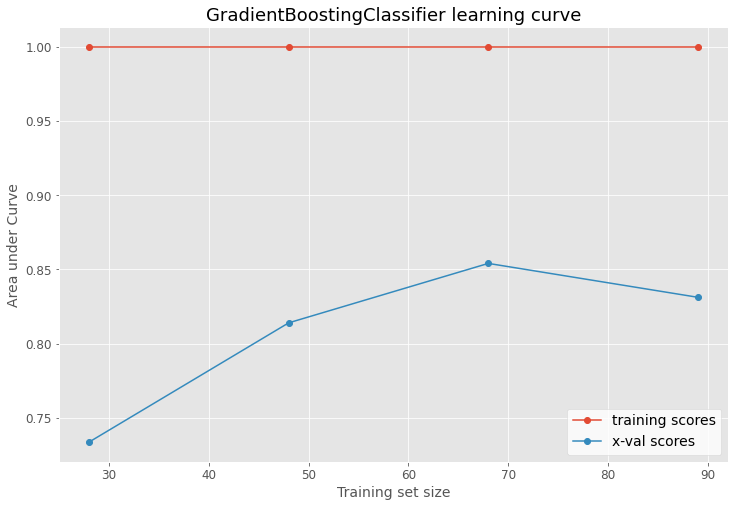

In [47]:
plot_learning_curves(GradientBoostingClassifier(random_state=0), data_train_X, data_train['Died'])

The learning curve of the GBM might be a little underfitting. Maybe reducing regularization of the model could lead to better performance. We'll use a randomised search to optimise hyperparameters.

In [48]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)

param_distribs = {
        'n_estimators': stats.randint(low=80, high=200),
        'max_depth': stats.randint(low=3, high=50),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
    }
rnd_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=0), 
                                param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=cv, scoring='roc_auc', random_state=0, n_jobs=-1)
# this will take a long time
rnd_search.fit(data_train_X, data_train['Died'])

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
                   estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A9790EC208>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A9790E56A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A9797E9DA0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A9798060B8>},
                   random_state=0, return_train_score=True, scoring='roc_auc')

In [49]:
cv_rlt = rnd_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.865332      0.999644   
1       0.862231      0.999176   
2       0.861850      0.999998   
3       0.861021      1.000000   
4       0.860537      0.988233   
..           ...           ...   
95      0.500000      0.500000   
96      0.500000      0.500000   
97      0.500000      0.500000   
98      0.500000      0.500000   
99      0.500000      0.500000   

                                               Params  
0   {'max_depth': 46, 'min_samples_leaf': 15, 'min...  
1   {'max_depth': 38, 'min_samples_leaf': 13, 'min...  
2   {'max_depth': 18, 'min_samples_leaf': 13, 'min...  
3   {'max_depth': 43, 'min_samples_leaf': 13, 'min...  
4   {'max_depth': 27, 'min_samples_leaf': 14, 'min...  
..                                                ...  
95  {'max_depth': 30, 'min_samples_leaf': 95, 'min...  
96  {'max_depth': 22, 'min_samples_leaf': 74, 'min...  
97  {'max_depth': 16, 'min_samples_leaf': 60, 'min...  
98  {'max_depth': 3, 'min_samples_leaf': 77, 'min_...  
99  {'max_depth': 11, 'min_samples_leaf': 63, 'min...  

[100 rows x 3 columns]

We'll save the best model, retrain it on the whole dataset and save the model

In [50]:
gbm_clf = rnd_search.best_estimator_
gbm_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\gbm_clf_final_round.pk1', 'wb') as f:
    pickle.dump(gbm_clf, f)

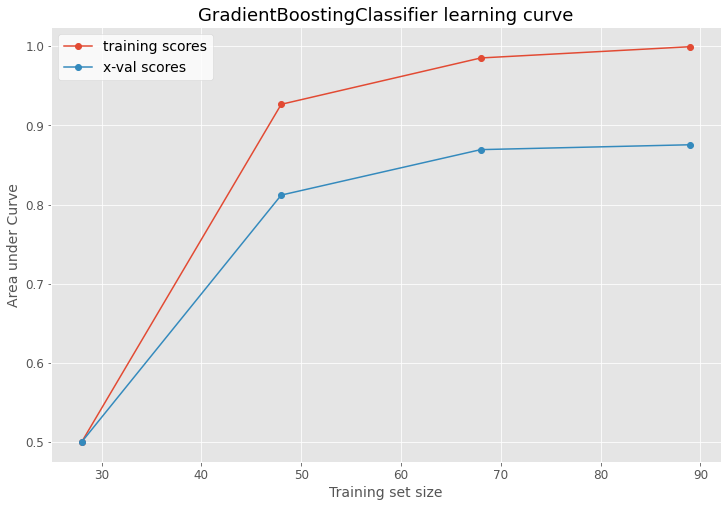

In [51]:
plot_learning_curves(gbm_clf, data_train_X, data_train['Died'])

The learning curve of the best Gradient Boosting model suggests that the performance of the model dramatically improves with more 30 traning data.

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

_plot the learning curve to find out where the default model is at_

Try Linear SVC fist

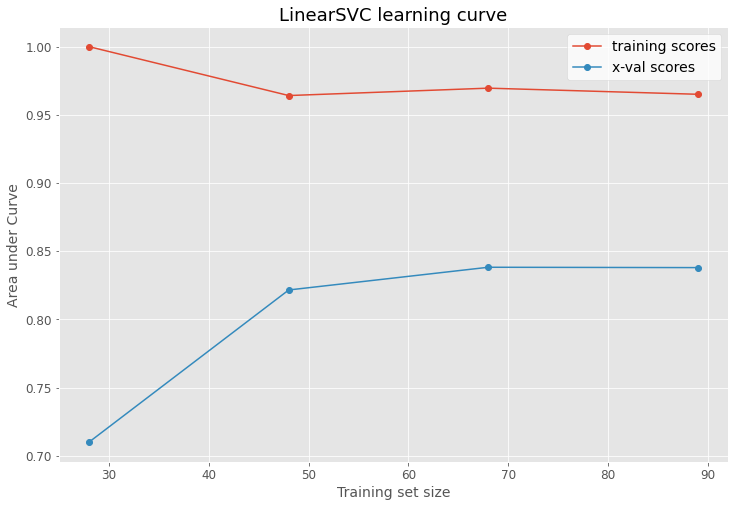

In [52]:
plot_learning_curves(LinearSVC(loss='hinge', random_state=0), data_train_X, data_train['Died'])

Try Polynomial kernel

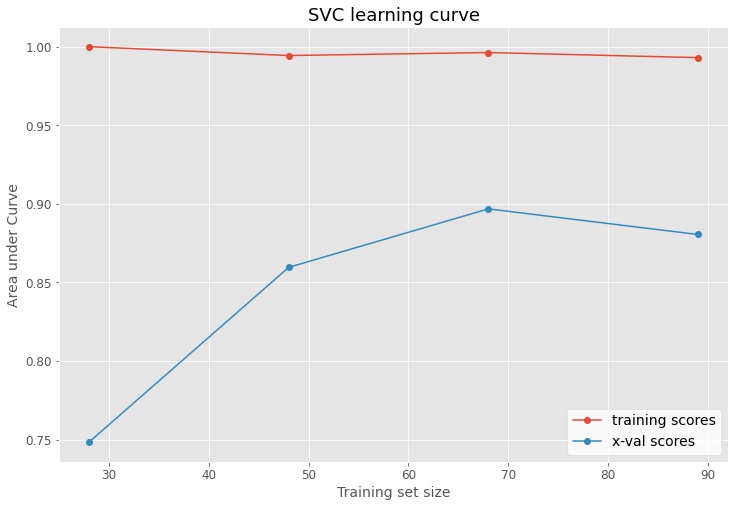

In [53]:
plot_learning_curves(SVC(kernel='poly', random_state=0), data_train_X, data_train['Died'])

Try Gaussian RBF kernel

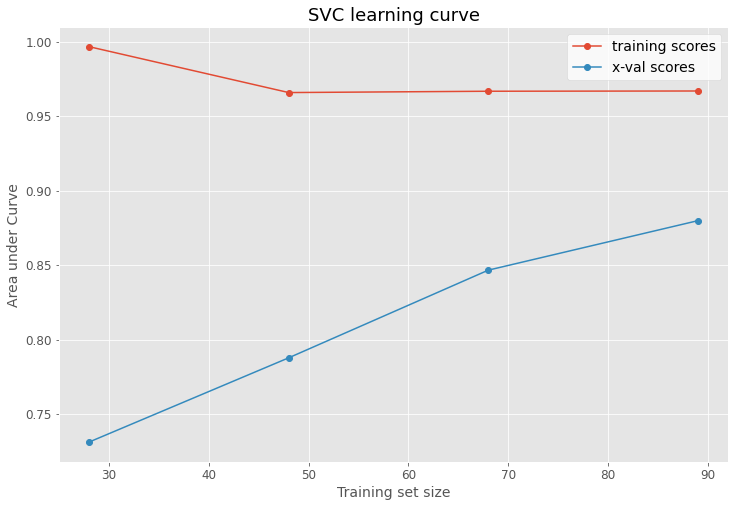

In [54]:
plot_learning_curves(SVC(kernel='rbf',random_state=0), data_train_X, data_train['Died'])

The Polynomial SVC shows that the default settings resulting in underfitted model, however, the performance is likely to improve if the complexity of the model increases, e.g., use higher degree polynomials.  

The default settings for RBF SVC performs the best, and with a gap between the training and validation accuracies, it is likely to improve the performance by regularization.

In [55]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)

rbf_gamma = [1/len(data_train_X.columns) * x for x in range(1, 15, 5)] #range(1, 20, 5)]
param_grid = [
    # first try Poly kernel
    ## coef0 hyper-parameter was also tested originally, however, it is taking too long
    {'kernel':['poly'], 'degree': [3, 9, 15], 'C': [1, 10, 100]},
    # then try RBF kernel
    {'gamma': rbf_gamma, 'C': [1, 10, 100]},
  ]

grid_search = GridSearchCV(SVC(probability=True, random_state=0), param_grid, cv=cv,
                           scoring='roc_auc', n_jobs=-1)

# this will take a long time
grid_search.fit(data_train_X, data_train['Died'])

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
             estimator=SVC(probability=True, random_state=0), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100], 'degree': [3, 9, 15],
                          'kernel': ['poly']},
                         {'C': [1, 10, 100],
                          'gamma': [0.03571428571428571, 0.21428571428571427,
                                    0.39285714285714285]}],
             scoring='roc_auc')

In [56]:
cv_rlt = grid_search.cv_results_
#pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['std_test_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores                                      Params
0       0.897187      0.059268     {'C': 1, 'degree': 3, 'kernel': 'poly'}
1       0.891631      0.057593    {'C': 10, 'degree': 3, 'kernel': 'poly'}
2       0.891631      0.057593   {'C': 100, 'degree': 3, 'kernel': 'poly'}
3       0.888013      0.059261    {'C': 100, 'gamma': 0.03571428571428571}
4       0.887047      0.059837     {'C': 10, 'gamma': 0.03571428571428571}
5       0.881015      0.068133      {'C': 1, 'gamma': 0.03571428571428571}
6       0.879878      0.066449     {'C': 1, 'degree': 9, 'kernel': 'poly'}
7       0.863945      0.068394     {'C': 10, 'gamma': 0.21428571428571427}
8       0.863945      0.068394    {'C': 100, 'gamma': 0.21428571428571427}
9       0.862787      0.067488    {'C': 10, 'degree': 9, 'kernel': 'poly'}
10      0.862787      0.067488   {'C': 100, 'degree': 9, 'kernel': 'poly'}
11      0.861431      0.070059      {'C': 1, 'gamma': 0.21428571428571427}
12      0.860641      0.074800    {'C': 1, 'degree': 15, 'kernel': 'poly'}
13      0.838542      0.074572     {'C': 10, 'gamma': 0.39285714285714285}
14      0.838542      0.074572    {'C': 100, 'gamma': 0.39285714285714285}
15      0.838164      0.075537      {'C': 1, 'gamma': 0.39285714285714285}
16      0.828837      0.078054   {'C': 10, 'degree': 15, 'kernel': 'poly'}
17      0.827006      0.078143  {'C': 100, 'degree': 15, 'kernel': 'poly'}

SVM training is very computationaly expensive, making it not scalable to big data sets. As it turns out the default RBF SVM results the best cross-validation score.

In [57]:
svc_clf = grid_search.best_estimator_
svc_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

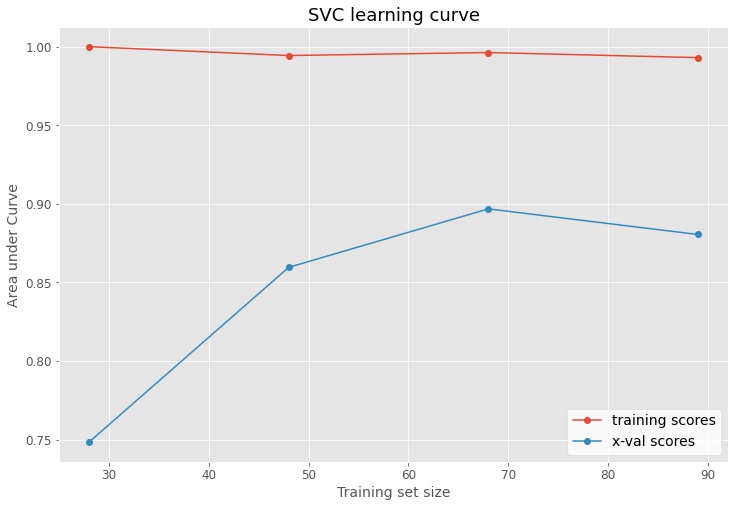

In [58]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, data_train_X, data_train['Died']) 

### AdaBoostClassifier classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

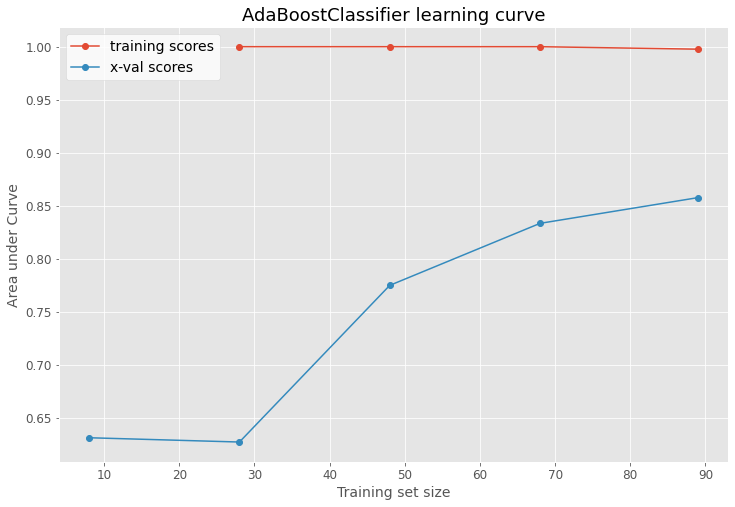

In [59]:
from sklearn.ensemble import AdaBoostClassifier

adab_clf = AdaBoostClassifier()
plot_learning_curves(adab_clf, data_train_X, data_train['Died'])

In [60]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 100, random_state = 0)

param_grid = {'n_estimators': [1,5,10,50],
        'learning_rate': [0.001,0.01,0.1,0.2,1] }
adab_clf = AdaBoostClassifier(random_state=0)
grid_search = GridSearchCV(adab_clf, param_grid=param_grid, return_train_score=True,
                           cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(data_train_X, data_train['Died'])

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=0),
             estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 1],
                         'n_estimators': [1, 5, 10, 50]},
             return_train_score=True, scoring='roc_auc')

In [61]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores                                        Params
0       0.842540      0.974508    {'learning_rate': 0.2, 'n_estimators': 50}
1       0.840354      0.949758    {'learning_rate': 0.1, 'n_estimators': 50}
2       0.836637      0.998244      {'learning_rate': 1, 'n_estimators': 50}
3       0.819927      0.907128    {'learning_rate': 0.2, 'n_estimators': 10}
4       0.805558      0.952365      {'learning_rate': 1, 'n_estimators': 10}
5       0.794724      0.879014    {'learning_rate': 0.1, 'n_estimators': 10}
6       0.776008      0.899393       {'learning_rate': 1, 'n_estimators': 5}
7       0.768175      0.863449     {'learning_rate': 0.2, 'n_estimators': 5}
8       0.755778      0.854580   {'learning_rate': 0.01, 'n_estimators': 50}
9       0.732973      0.834010     {'learning_rate': 0.1, 'n_estimators': 5}
10      0.665090      0.756444   {'learning_rate': 0.01, 'n_estimators': 10}
11      0.650958      0.736366  {'learning_rate': 0.001, 'n_estimators': 50}
12      0.646724      0.731209    {'learning_rate': 0.01, 'n_estimators': 5}
13      0.630423      0.711232  {'learning_rate': 0.001, 'n_estimators': 10}
14      0.629095      0.708267   {'learning_rate': 0.001, 'n_estimators': 5}
15      0.625717      0.705262   {'learning_rate': 0.001, 'n_estimators': 1}
16      0.625717      0.705262    {'learning_rate': 0.01, 'n_estimators': 1}
17      0.625717      0.705262     {'learning_rate': 0.1, 'n_estimators': 1}
18      0.625717      0.705262     {'learning_rate': 0.2, 'n_estimators': 1}
19      0.625717      0.705262       {'learning_rate': 1, 'n_estimators': 1}

In [62]:
adab_clf = grid_search.best_estimator_
adab_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\adab_clf_final_round.pk1', 'wb') as f:
    pickle.dump(adab_clf, f)

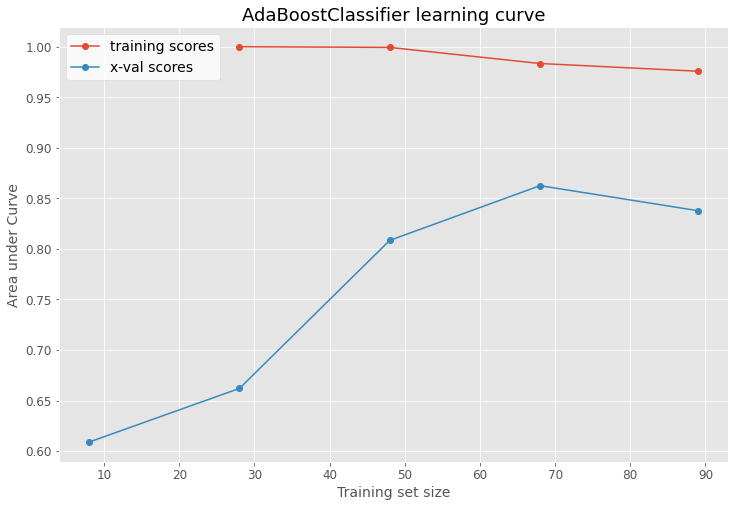

In [63]:
plot_learning_curves(adab_clf, data_train_X, data_train['Died'])

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

### Ensemble classifier
Scikit-learn offers a voting classifier which aggregates the prediction of multiple predictors and is a flexible ensemble technique that allows an ensemble of different models.  
For the final classifier, simply aggregate the predictions of the three best models, i.e., logistic regression,random forests, gradien boosting machine and the support vector machine.
https://www.kaggle.com/rafjaa/dealing-with-very-small-datasets

In [64]:
#ensemble_clf = VotingClassifier(estimators=[('rf', rf_clf), ('gbm', gbm_clf), ('svc', svc_clf)],
ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf), ('rf', rf_clf), ('gbm', gbm_clf), ('svc', svc_clf), ('adab', adab_clf)],
                             voting='soft')
ensemble_clf.fit(data_train_X, data_train['Died'])

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=0)),
                             ('rf',
                              RandomForestClassifier(max_depth=23,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=12,
                                                     n_estimators=44,
                                                     random_state=0)),
                             ('gbm',
                              GradientBoostingClassifier(max_depth=46,
                                                         min_samples_leaf=15,
                                                         min_samples_split=42,
                                                         n_estimators=152,
                                                         random_state=0)),
                             ('svc',
    

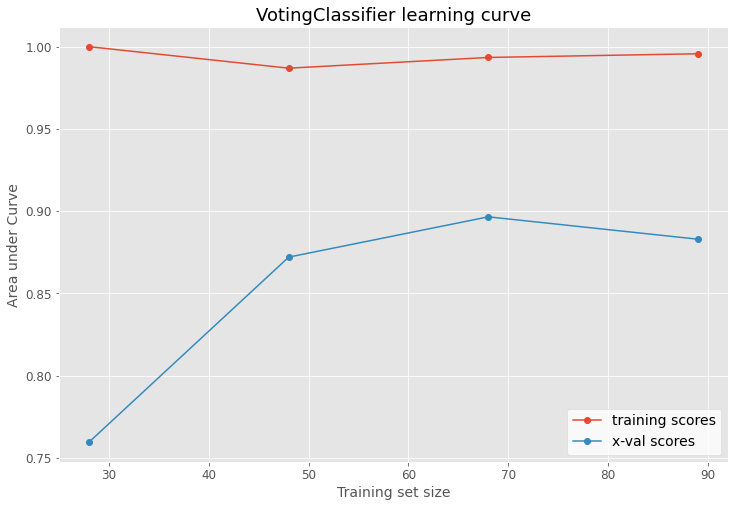

In [65]:
plot_learning_curves(ensemble_clf, data_train_X, data_train['Died'])

In [66]:
#ensemble_clf = grid_search.best_estimator_
ensemble_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\ensemble_clf_final_round.pkl', 'wb') as f:
    pickle.dump(ensemble_clf, f)

## 6. Compute and compare test metrics

**Transform test data set**

In [44]:
data_test_X = pd.DataFrame(preproc_pipeline.transform(data_test), # it's imperative not to do fit_transfomr again
                           columns=categorical_vars + continuous_vars)
#columns=categorical_vars + numerical_vars)

C:\Users\neo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\neo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\neo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [45]:
data_test_X.shape

(38, 28)

In [46]:
data_test_X.head()

Gender  Age  BMI  Comorbidity_diabetes  Comorbidity_hypertension  \
0       0    2    0                     0                         0   
1       0    1    1                     0                         0   
2       0    2    2                     0                         0   
3       0    1    2                     0                         1   
4       1    2    2                     0                         1   

   Comorbidity_CAD  Comorbidity_pulmonary  Comorbidity_hepatic  \
0                1                      1                    0   
1                0                      0                    0   
2                0                      0                    0   
3                1                      1                    0   
4                1                      0                    0   

   Comorbidity_renal  Comorbidity_neurological  ...  Defibrillate  \
0                  0                         1  ...             0   
1                  0                         0  ...             0   
2                  0                         0  ...             1   
3                  0                         0  ...             0   
4                  0                         0  ...             0   

   Cause_arrest  Hemorrhage  Blood_transfusion  Epinephrine  Atropine  \
0             1           0                  0            1         0   
1             3           2                  2            1         0   
2             1           0                  0            1         0   
3             1           1                  0            2         1   
4             2           2                  2            2         0   

   Amiodarone  Ephedrine  Methoxamine  CPR  
0           0          0            1    0  
1           0          0            0    1  
2           1          0            0    2  
3           0          0            0    2  
4           0          0            0    1  

[5 rows x 28 columns]

**Compute test accuracy score**

In [47]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

### _Logistic Regression model_

In [48]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\lr_clf_final_round.pk1', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(data_train_X, data_train['Died'])

LogisticRegression(C=1, random_state=0)

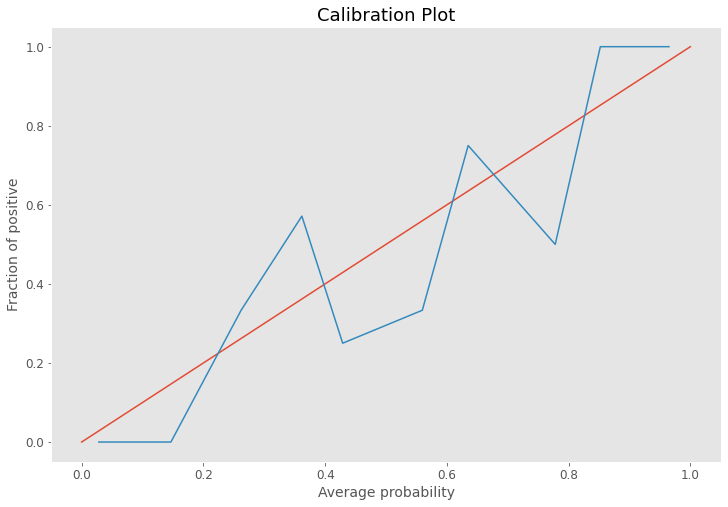

In [50]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
lr_clf.fit(data_train_X, data_train['Died'])

prob = lr_clf.decision_function(data_test_X) # output probability of the model

fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Calibration Plot")
plt.show()

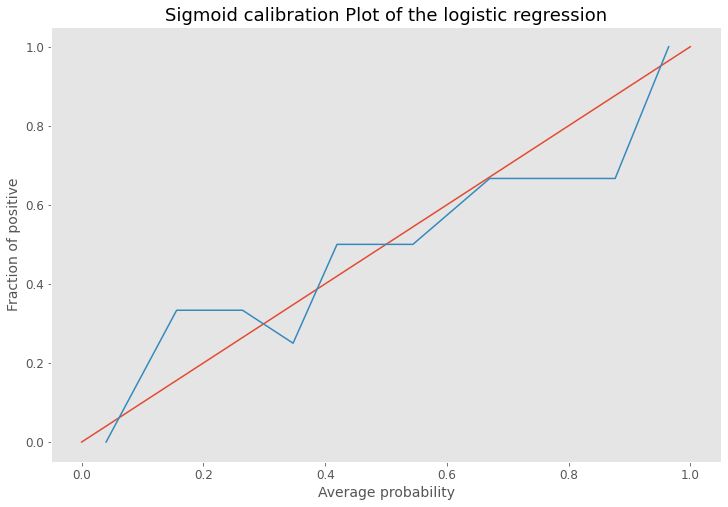

In [62]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(lr_clf,method='sigmoid',cv=5)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Sigmoid calibration Plot of the logistic regression")
plt.show()

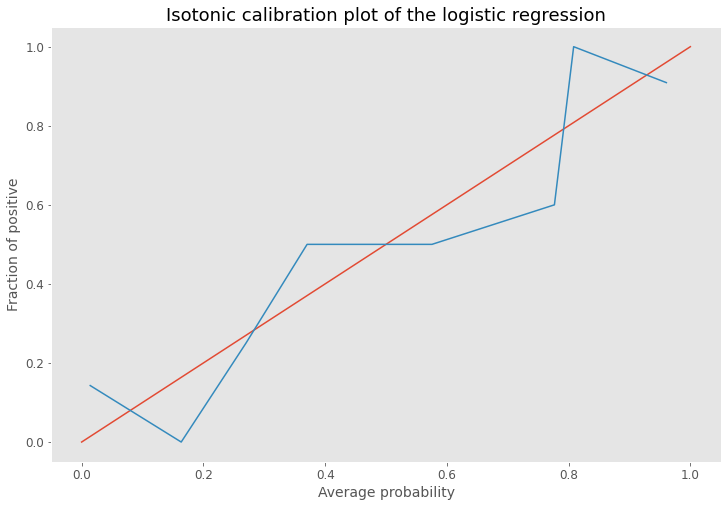

In [66]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(lr_clf,method='isotonic',cv=5)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Isotonic calibration plot of the logistic regression")
plt.show()

Calculation of AUC 95 % CI from Cross Validation

Cross-validation or bootstrapping to evaluate classification performance?

https://stats.stackexchange.com/questions/71184/cross-validation-or-bootstrapping-to-evaluate-classification-performance?rq=1
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

https://towardsdatascience.com/pooled-roc-with-xgboost-and-plotly-553a8169680c

In [124]:
#pred_proba_lr = lr_clf.predict_proba(data_test_X)
pred_proba_lr = lr_clf.predict_proba(data_train_X)

In [125]:
import scipy.stats

y_pred = np.array(pred_proba_lr[:, 1])

#y_pred = np.array(lr_clf.predict(data_test_X))

#y_true = np.array(data_test['Died'])
y_true = np.array(data_train['Died'])    
#print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred))) 


n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
       
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.970
Bootstrap #1 ROC area: 0.978
Bootstrap #2 ROC area: 0.987
Bootstrap #3 ROC area: 0.976
Bootstrap #4 ROC area: 0.978
Bootstrap #5 ROC area: 0.960
Bootstrap #6 ROC area: 0.989
Bootstrap #7 ROC area: 0.970
Bootstrap #8 ROC area: 0.976
Bootstrap #9 ROC area: 0.975
Bootstrap #10 ROC area: 0.957
Bootstrap #11 ROC area: 0.995
Bootstrap #12 ROC area: 0.996
Bootstrap #13 ROC area: 0.989
Bootstrap #14 ROC area: 0.975
Bootstrap #15 ROC area: 0.977
Bootstrap #16 ROC area: 0.983
Bootstrap #17 ROC area: 0.993
Bootstrap #18 ROC area: 0.976
Bootstrap #19 ROC area: 0.970
Bootstrap #20 ROC area: 0.940
Bootstrap #21 ROC area: 0.937
Bootstrap #22 ROC area: 0.972
Bootstrap #23 ROC area: 0.972
Bootstrap #24 ROC area: 0.996
Bootstrap #25 ROC area: 0.961
Bootstrap #26 ROC area: 0.964
Bootstrap #27 ROC area: 0.982
Bootstrap #28 ROC area: 0.958
Bootstrap #29 ROC area: 0.964
Bootstrap #30 ROC area: 0.969
Bootstrap #31 ROC area: 0.946
Bootstrap #32 ROC area: 0.985
Bootstrap #33 ROC area: 

Bootstrap #348 ROC area: 0.945
Bootstrap #349 ROC area: 0.971
Bootstrap #350 ROC area: 0.986
Bootstrap #351 ROC area: 0.975
Bootstrap #352 ROC area: 0.974
Bootstrap #353 ROC area: 0.965
Bootstrap #354 ROC area: 0.979
Bootstrap #355 ROC area: 0.963
Bootstrap #356 ROC area: 0.973
Bootstrap #357 ROC area: 0.967
Bootstrap #358 ROC area: 0.987
Bootstrap #359 ROC area: 0.955
Bootstrap #360 ROC area: 0.981
Bootstrap #361 ROC area: 0.958
Bootstrap #362 ROC area: 0.985
Bootstrap #363 ROC area: 0.944
Bootstrap #364 ROC area: 0.978
Bootstrap #365 ROC area: 0.973
Bootstrap #366 ROC area: 0.974
Bootstrap #367 ROC area: 0.941
Bootstrap #368 ROC area: 0.964
Bootstrap #369 ROC area: 0.998
Bootstrap #370 ROC area: 0.942
Bootstrap #371 ROC area: 0.988
Bootstrap #372 ROC area: 0.968
Bootstrap #373 ROC area: 0.970
Bootstrap #374 ROC area: 0.967
Bootstrap #375 ROC area: 0.937
Bootstrap #376 ROC area: 0.960
Bootstrap #377 ROC area: 0.977
Bootstrap #378 ROC area: 0.967
Bootstrap #379 ROC area: 0.968
Bootstra

Bootstrap #656 ROC area: 0.975
Bootstrap #657 ROC area: 0.992
Bootstrap #658 ROC area: 0.994
Bootstrap #659 ROC area: 0.958
Bootstrap #660 ROC area: 0.979
Bootstrap #661 ROC area: 0.991
Bootstrap #662 ROC area: 0.948
Bootstrap #663 ROC area: 0.953
Bootstrap #664 ROC area: 0.938
Bootstrap #665 ROC area: 0.955
Bootstrap #666 ROC area: 0.988
Bootstrap #667 ROC area: 0.967
Bootstrap #668 ROC area: 0.977
Bootstrap #669 ROC area: 0.966
Bootstrap #670 ROC area: 0.982
Bootstrap #671 ROC area: 0.961
Bootstrap #672 ROC area: 0.945
Bootstrap #673 ROC area: 0.979
Bootstrap #674 ROC area: 0.989
Bootstrap #675 ROC area: 0.968
Bootstrap #676 ROC area: 0.990
Bootstrap #677 ROC area: 0.987
Bootstrap #678 ROC area: 0.987
Bootstrap #679 ROC area: 0.983
Bootstrap #680 ROC area: 0.962
Bootstrap #681 ROC area: 0.942
Bootstrap #682 ROC area: 0.991
Bootstrap #683 ROC area: 0.970
Bootstrap #684 ROC area: 0.985
Bootstrap #685 ROC area: 0.953
Bootstrap #686 ROC area: 0.957
Bootstrap #687 ROC area: 0.972
Bootstra

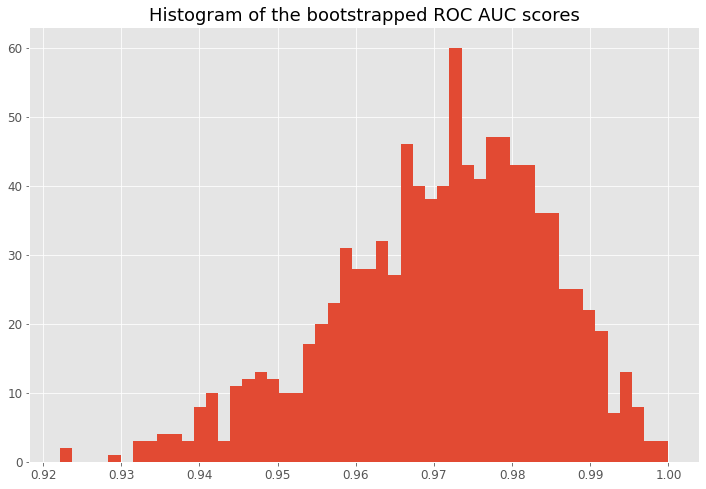

In [126]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [127]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.940 - 0.994]


#### ROC with confidence intervals (+- SD)

Original ROC area: 0.842


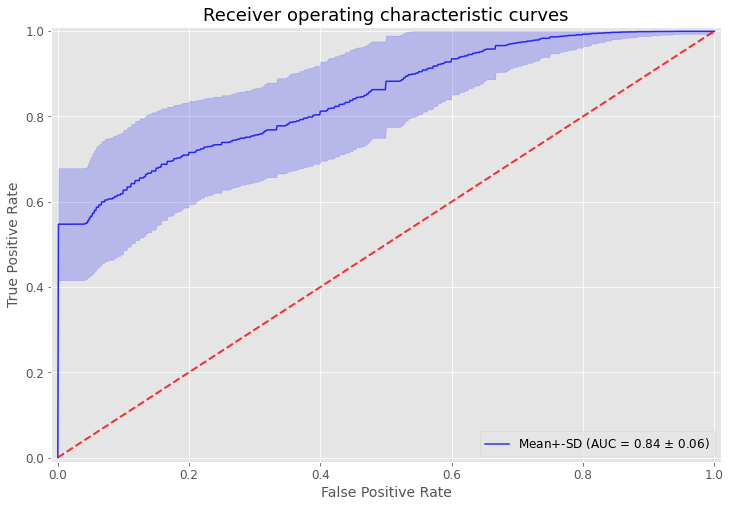

In [76]:
y_pred = np.array(pred_proba_lr[:, 1])
#y_pred = np.array(lr_clf.predict(data_test_X))

y_true = np.array(data_test['Died'])
    
#print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred))) 

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 1001)
colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
        
    fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    #AUC_score = roc_auc_score(y_true[indices], y_pred[indices])
       
    #bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

mean_auc = auc(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + std, 1) ##95% confindence interval=1.96 times standard deviation
tprs_lower = mean_tprs - std

plt.figure(figsize=(12, 8))
plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Mean+-SD (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = '', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic curves')
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

### Classification report

False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.89      0.96      0.92        50
           1       0.97      0.90      0.93        62

    accuracy                           0.93       112
   macro avg       0.93      0.93      0.93       112
weighted avg       0.93      0.93      0.93       112



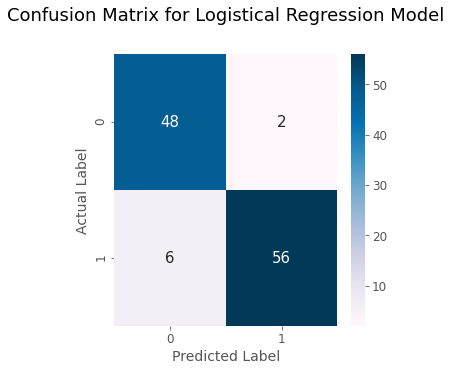

AUC :  0.9703225806451613
Recall/Sensitivity/TPR :  0.9032258064516129
Fall-out/False positive rate :  0.04
Selectivity/Specificity/TNR :  0.96


In [130]:
#pred=lr_clf.predict(data_test_X)
pred=lr_clf.predict(data_train_X)

#pred_prob = lr_clf.predict_proba(data_test_X)[:, 1]
pred_prob = lr_clf.predict_proba(data_train_X)[:, 1]

#report = classification_report(data_test['Died'], pred)
report = classification_report(data_train['Died'], pred)

#confusion = confusion_matrix(data_test['Died'], pred).T
confusion = confusion_matrix(data_train['Died'], pred).T

confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
#cm = confusion_matrix(data_test['Died'], pred)
cm = confusion_matrix(data_train['Died'], pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for Logistical Regression Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

#print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_lr[:, 1]))
print('AUC : ', roc_auc_score(data_train['Died'], pred_proba_lr[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

### _Random forests model_

In [57]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(data_train_X, data_train['Died'])

RandomForestClassifier(max_depth=23, max_features='log2', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=44, random_state=0)

In [69]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
rf_clf.fit(data_train_X, data_train['Died'])

prob = rf_clf.decision_function(data_test_X) # output probability of the model

fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Calibration Plot")
plt.show()

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

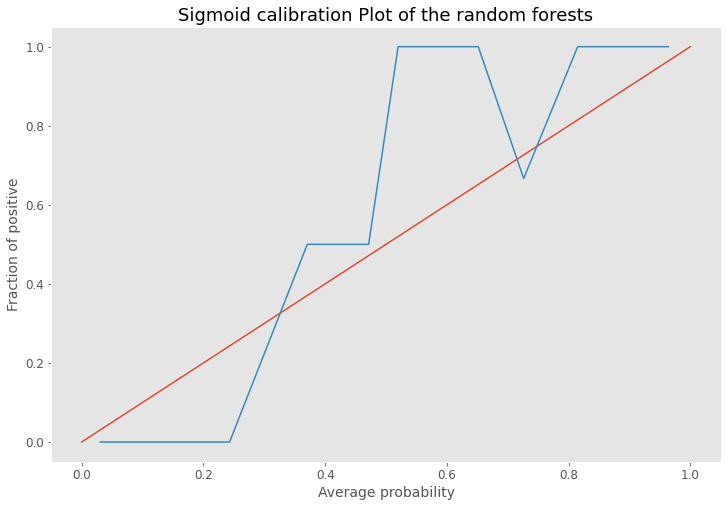

In [95]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(rf_clf,method='sigmoid',cv=10)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Sigmoid calibration Plot of the random forests")
plt.show()

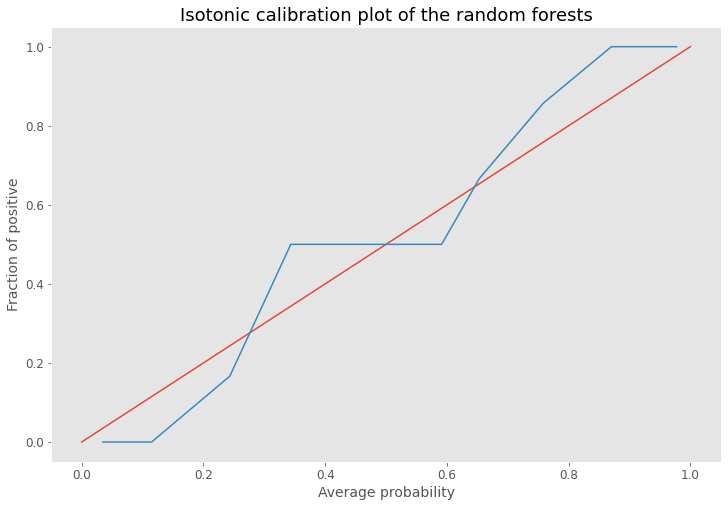

In [101]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(rf_clf,method='isotonic',cv=40)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Isotonic calibration plot of the random forests")
plt.show()

Calculation of AUC 95 % CI from Cross Validation

Cross-validation or bootstrapping to evaluate classification performance?

https://stats.stackexchange.com/questions/71184/cross-validation-or-bootstrapping-to-evaluate-classification-performance?rq=1
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

In [131]:
import scipy.stats

#pred_proba_rf = rf_clf.predict_proba(data_test_X)
pred_proba_rf = rf_clf.predict_proba(data_train_X)

y_pred = np.array(pred_proba_rf[:, 1])
#y_true = np.array(data_test['Died'])
y_true = np.array(data_train['Died'])
    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.981
Bootstrap #1 ROC area: 0.987
Bootstrap #2 ROC area: 0.990
Bootstrap #3 ROC area: 0.991
Bootstrap #4 ROC area: 0.981
Bootstrap #5 ROC area: 0.977
Bootstrap #6 ROC area: 0.990
Bootstrap #7 ROC area: 0.979
Bootstrap #8 ROC area: 0.985
Bootstrap #9 ROC area: 0.982
Bootstrap #10 ROC area: 0.969
Bootstrap #11 ROC area: 1.000
Bootstrap #12 ROC area: 0.995
Bootstrap #13 ROC area: 0.993
Bootstrap #14 ROC area: 0.979
Bootstrap #15 ROC area: 0.987
Bootstrap #16 ROC area: 0.990
Bootstrap #17 ROC area: 0.996
Bootstrap #18 ROC area: 0.987
Bootstrap #19 ROC area: 0.978
Bootstrap #20 ROC area: 0.949
Bootstrap #21 ROC area: 0.974
Bootstrap #22 ROC area: 0.975
Bootstrap #23 ROC area: 0.978
Bootstrap #24 ROC area: 0.995
Bootstrap #25 ROC area: 0.978
Bootstrap #26 ROC area: 0.969
Bootstrap #27 ROC area: 0.990
Bootstrap #28 ROC area: 0.959
Bootstrap #29 ROC area: 0.990
Bootstrap #30 ROC area: 0.988
Bootstrap #31 ROC area: 0.972
Bootstrap #32 ROC area: 0.989
Bootstrap #33 ROC area: 

Bootstrap #286 ROC area: 0.983
Bootstrap #287 ROC area: 0.968
Bootstrap #288 ROC area: 0.974
Bootstrap #289 ROC area: 0.986
Bootstrap #290 ROC area: 0.995
Bootstrap #291 ROC area: 0.981
Bootstrap #292 ROC area: 0.963
Bootstrap #293 ROC area: 0.983
Bootstrap #294 ROC area: 0.988
Bootstrap #295 ROC area: 0.983
Bootstrap #296 ROC area: 0.977
Bootstrap #297 ROC area: 0.988
Bootstrap #298 ROC area: 0.962
Bootstrap #299 ROC area: 0.978
Bootstrap #300 ROC area: 0.977
Bootstrap #301 ROC area: 0.975
Bootstrap #302 ROC area: 0.983
Bootstrap #303 ROC area: 0.988
Bootstrap #304 ROC area: 0.986
Bootstrap #305 ROC area: 0.992
Bootstrap #306 ROC area: 0.982
Bootstrap #307 ROC area: 1.000
Bootstrap #308 ROC area: 0.976
Bootstrap #309 ROC area: 0.983
Bootstrap #310 ROC area: 0.986
Bootstrap #311 ROC area: 0.976
Bootstrap #312 ROC area: 0.975
Bootstrap #313 ROC area: 0.992
Bootstrap #314 ROC area: 0.987
Bootstrap #315 ROC area: 0.976
Bootstrap #316 ROC area: 0.984
Bootstrap #317 ROC area: 0.994
Bootstra

Bootstrap #605 ROC area: 0.992
Bootstrap #606 ROC area: 0.992
Bootstrap #607 ROC area: 0.964
Bootstrap #608 ROC area: 0.996
Bootstrap #609 ROC area: 0.992
Bootstrap #610 ROC area: 0.983
Bootstrap #611 ROC area: 0.982
Bootstrap #612 ROC area: 0.987
Bootstrap #613 ROC area: 0.982
Bootstrap #614 ROC area: 0.969
Bootstrap #615 ROC area: 0.962
Bootstrap #616 ROC area: 0.988
Bootstrap #617 ROC area: 0.977
Bootstrap #618 ROC area: 0.988
Bootstrap #619 ROC area: 0.975
Bootstrap #620 ROC area: 0.989
Bootstrap #621 ROC area: 0.994
Bootstrap #622 ROC area: 0.977
Bootstrap #623 ROC area: 0.987
Bootstrap #624 ROC area: 0.986
Bootstrap #625 ROC area: 0.978
Bootstrap #626 ROC area: 0.973
Bootstrap #627 ROC area: 0.980
Bootstrap #628 ROC area: 0.969
Bootstrap #629 ROC area: 0.966
Bootstrap #630 ROC area: 0.988
Bootstrap #631 ROC area: 0.977
Bootstrap #632 ROC area: 0.988
Bootstrap #633 ROC area: 0.971
Bootstrap #634 ROC area: 0.967
Bootstrap #635 ROC area: 0.991
Bootstrap #636 ROC area: 0.978
Bootstra

Bootstrap #914 ROC area: 0.988
Bootstrap #915 ROC area: 0.980
Bootstrap #916 ROC area: 0.970
Bootstrap #917 ROC area: 1.000
Bootstrap #918 ROC area: 0.975
Bootstrap #919 ROC area: 0.983
Bootstrap #920 ROC area: 0.969
Bootstrap #921 ROC area: 0.997
Bootstrap #922 ROC area: 0.999
Bootstrap #923 ROC area: 0.993
Bootstrap #924 ROC area: 0.988
Bootstrap #925 ROC area: 0.970
Bootstrap #926 ROC area: 0.981
Bootstrap #927 ROC area: 0.980
Bootstrap #928 ROC area: 0.992
Bootstrap #929 ROC area: 0.985
Bootstrap #930 ROC area: 0.986
Bootstrap #931 ROC area: 0.962
Bootstrap #932 ROC area: 0.997
Bootstrap #933 ROC area: 0.948
Bootstrap #934 ROC area: 0.986
Bootstrap #935 ROC area: 0.985
Bootstrap #936 ROC area: 0.983
Bootstrap #937 ROC area: 0.982
Bootstrap #938 ROC area: 0.950
Bootstrap #939 ROC area: 0.976
Bootstrap #940 ROC area: 0.984
Bootstrap #941 ROC area: 0.983
Bootstrap #942 ROC area: 0.971
Bootstrap #943 ROC area: 0.984
Bootstrap #944 ROC area: 0.996
Bootstrap #945 ROC area: 0.982
Bootstra

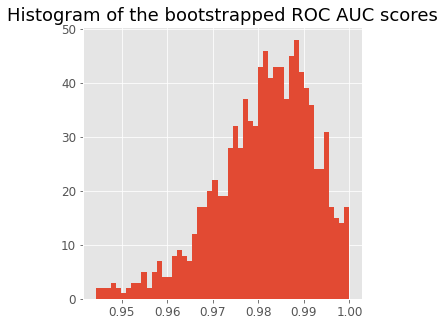

In [132]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [133]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.956 - 0.998]


#### ROC with confidence intervals (+- SD)

Original ROC area: 0.908


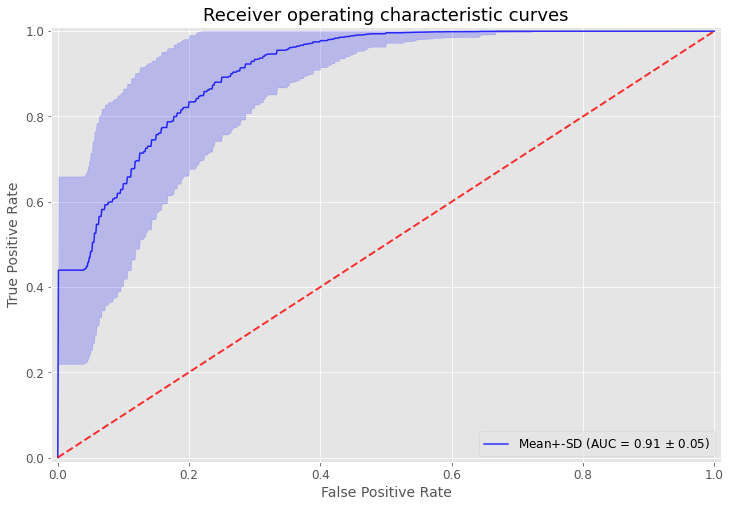

In [82]:
y_pred = np.array(pred_proba_rf[:, 1])
y_true = np.array(data_test['Died'])
    
#print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred))) 

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 1001)
colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
        
    fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    #AUC_score = roc_auc_score(y_true[indices], y_pred[indices])
       
    #bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

mean_auc = auc(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + std, 1) ##95% confindence interval=1.96 times standard deviation
tprs_lower = mean_tprs - std

plt.figure(figsize=(12, 8))
plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Mean+-SD (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = '', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic curves')
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        50
           1       0.94      0.98      0.96        62

    accuracy                           0.96       112
   macro avg       0.96      0.95      0.95       112
weighted avg       0.96      0.96      0.96       112



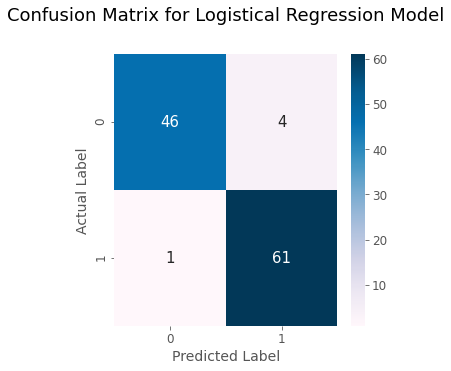

AUC :  0.9703225806451613
Recall/Sensitivity/TPR :  0.9838709677419355
Fall-out/False positive rate :  0.08
Selectivity/Specificity/TNR :  0.92


In [135]:
#pred=lr_clf.predict(data_test_X)
pred=rf_clf.predict(data_train_X)

#pred_prob = lr_clf.predict_proba(data_test_X)[:, 1]
pred_prob = rf_clf.predict_proba(data_train_X)[:, 1]

#report = classification_report(data_test['Died'], pred)
report = classification_report(data_train['Died'], pred)

#confusion = confusion_matrix(data_test['Died'], pred).T
confusion = confusion_matrix(data_train['Died'], pred).T

confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
#cm = confusion_matrix(data_test['Died'], pred)
cm = confusion_matrix(data_train['Died'], pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for Logistical Regression Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

#print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_lr[:, 1]))
print('AUC : ', roc_auc_score(data_train['Died'], pred_proba_lr[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion


False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.84      0.80      0.82        20

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.82      0.82      0.82        38



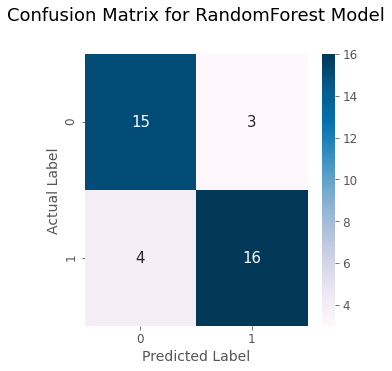

AUC :  0.9083333333333334
Recall/Sensitivity/TPR :  0.8
Fall-out/False positive rate :  0.16666666666666666
Selectivity/Specificity/TNR :  0.8333333333333334


In [83]:
pred=rf_clf.predict(data_test_X)

pred_prob = rf_clf.predict_proba(data_test_X)[:, 1]
report = classification_report(data_test['Died'], pred)

confusion = confusion_matrix(data_test['Died'], pred).T
confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
cm = confusion_matrix(data_test['Died'], pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for RandomForest Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_rf[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

### _Gradient boosting machine model_

In [136]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\gbm_clf_final_round.pk1', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(data_train_X, data_train['Died'])

GradientBoostingClassifier(max_depth=46, min_samples_leaf=15,
                           min_samples_split=42, n_estimators=152,
                           random_state=0)

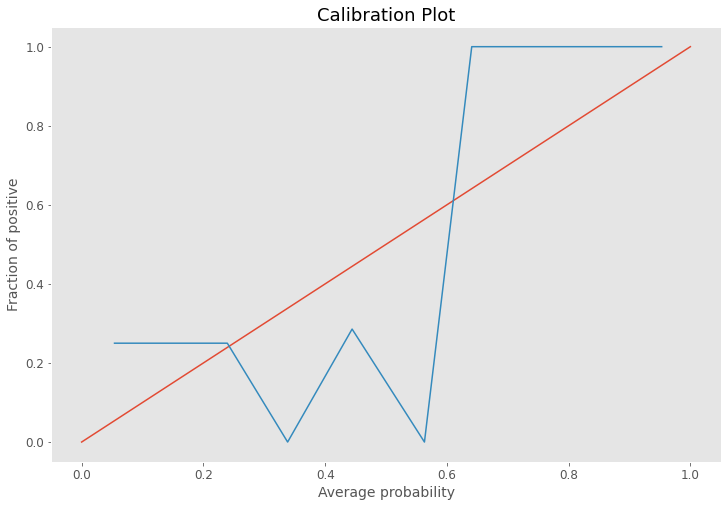

In [73]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
gbm_clf.fit(data_train_X, data_train['Died'])

prob = gbm_clf.decision_function(data_test_X) # output probability of the model

fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Calibration Plot")
plt.show()

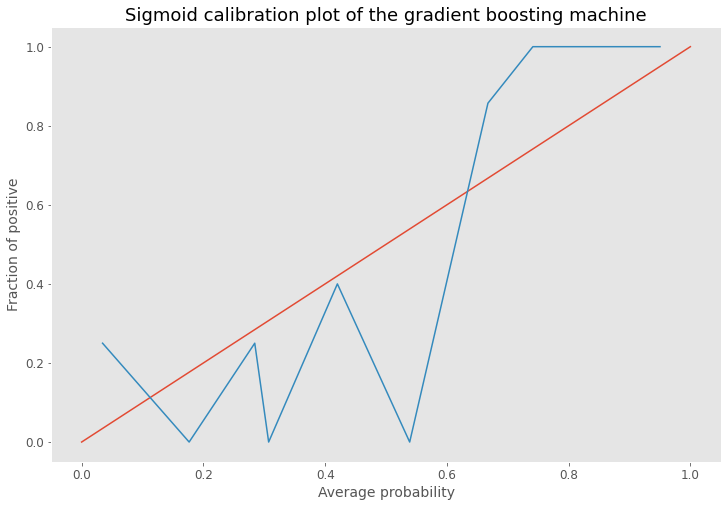

In [103]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(gbm_clf,method='sigmoid',cv=20)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Sigmoid calibration plot of the gradient boosting machine")
plt.show()

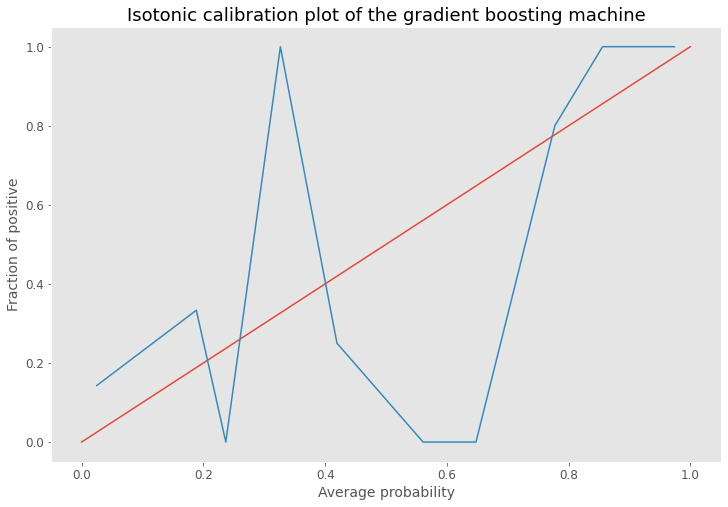

In [113]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(gbm_clf,method='isotonic',cv=15)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Isotonic calibration plot of the gradient boosting machine")
plt.show()

Calculation of AUC 95 % CI from Cross Validation

Cross-validation or bootstrapping to evaluate classification performance?

https://stats.stackexchange.com/questions/71184/cross-validation-or-bootstrapping-to-evaluate-classification-performance?rq=1
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

In [137]:
import scipy.stats


#pred_proba_gbm = gbm_clf.predict_proba(data_test_X)
pred_proba_gbm = gbm_clf.predict_proba(data_train_X)

y_pred = np.array(pred_proba_gbm[:, 1])
#y_true = np.array(data_test['Died'])
y_true = np.array(data_train['Died'])
    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 1.000
Bootstrap #1 ROC area: 1.000
Bootstrap #2 ROC area: 1.000
Bootstrap #3 ROC area: 1.000
Bootstrap #4 ROC area: 1.000
Bootstrap #5 ROC area: 1.000
Bootstrap #6 ROC area: 1.000
Bootstrap #7 ROC area: 1.000
Bootstrap #8 ROC area: 1.000
Bootstrap #9 ROC area: 1.000
Bootstrap #10 ROC area: 1.000
Bootstrap #11 ROC area: 1.000
Bootstrap #12 ROC area: 1.000
Bootstrap #13 ROC area: 1.000
Bootstrap #14 ROC area: 1.000
Bootstrap #15 ROC area: 1.000
Bootstrap #16 ROC area: 1.000
Bootstrap #17 ROC area: 1.000
Bootstrap #18 ROC area: 1.000
Bootstrap #19 ROC area: 1.000
Bootstrap #20 ROC area: 1.000
Bootstrap #21 ROC area: 1.000
Bootstrap #22 ROC area: 1.000
Bootstrap #23 ROC area: 1.000
Bootstrap #24 ROC area: 1.000
Bootstrap #25 ROC area: 1.000
Bootstrap #26 ROC area: 1.000
Bootstrap #27 ROC area: 1.000
Bootstrap #28 ROC area: 1.000
Bootstrap #29 ROC area: 1.000
Bootstrap #30 ROC area: 1.000
Bootstrap #31 ROC area: 1.000
Bootstrap #32 ROC area: 1.000
Bootstrap #33 ROC area: 

Bootstrap #348 ROC area: 1.000
Bootstrap #349 ROC area: 1.000
Bootstrap #350 ROC area: 1.000
Bootstrap #351 ROC area: 1.000
Bootstrap #352 ROC area: 1.000
Bootstrap #353 ROC area: 1.000
Bootstrap #354 ROC area: 1.000
Bootstrap #355 ROC area: 1.000
Bootstrap #356 ROC area: 1.000
Bootstrap #357 ROC area: 1.000
Bootstrap #358 ROC area: 1.000
Bootstrap #359 ROC area: 1.000
Bootstrap #360 ROC area: 1.000
Bootstrap #361 ROC area: 1.000
Bootstrap #362 ROC area: 1.000
Bootstrap #363 ROC area: 1.000
Bootstrap #364 ROC area: 1.000
Bootstrap #365 ROC area: 1.000
Bootstrap #366 ROC area: 1.000
Bootstrap #367 ROC area: 1.000
Bootstrap #368 ROC area: 1.000
Bootstrap #369 ROC area: 1.000
Bootstrap #370 ROC area: 1.000
Bootstrap #371 ROC area: 1.000
Bootstrap #372 ROC area: 1.000
Bootstrap #373 ROC area: 1.000
Bootstrap #374 ROC area: 1.000
Bootstrap #375 ROC area: 1.000
Bootstrap #376 ROC area: 1.000
Bootstrap #377 ROC area: 1.000
Bootstrap #378 ROC area: 1.000
Bootstrap #379 ROC area: 1.000
Bootstra

Bootstrap #618 ROC area: 1.000
Bootstrap #619 ROC area: 1.000
Bootstrap #620 ROC area: 1.000
Bootstrap #621 ROC area: 1.000
Bootstrap #622 ROC area: 1.000
Bootstrap #623 ROC area: 1.000
Bootstrap #624 ROC area: 1.000
Bootstrap #625 ROC area: 1.000
Bootstrap #626 ROC area: 1.000
Bootstrap #627 ROC area: 1.000
Bootstrap #628 ROC area: 1.000
Bootstrap #629 ROC area: 1.000
Bootstrap #630 ROC area: 1.000
Bootstrap #631 ROC area: 1.000
Bootstrap #632 ROC area: 1.000
Bootstrap #633 ROC area: 1.000
Bootstrap #634 ROC area: 1.000
Bootstrap #635 ROC area: 1.000
Bootstrap #636 ROC area: 1.000
Bootstrap #637 ROC area: 1.000
Bootstrap #638 ROC area: 1.000
Bootstrap #639 ROC area: 1.000
Bootstrap #640 ROC area: 1.000
Bootstrap #641 ROC area: 1.000
Bootstrap #642 ROC area: 1.000
Bootstrap #643 ROC area: 1.000
Bootstrap #644 ROC area: 1.000
Bootstrap #645 ROC area: 1.000
Bootstrap #646 ROC area: 1.000
Bootstrap #647 ROC area: 1.000
Bootstrap #648 ROC area: 1.000
Bootstrap #649 ROC area: 1.000
Bootstra

Bootstrap #928 ROC area: 1.000
Bootstrap #929 ROC area: 1.000
Bootstrap #930 ROC area: 1.000
Bootstrap #931 ROC area: 1.000
Bootstrap #932 ROC area: 1.000
Bootstrap #933 ROC area: 1.000
Bootstrap #934 ROC area: 1.000
Bootstrap #935 ROC area: 1.000
Bootstrap #936 ROC area: 1.000
Bootstrap #937 ROC area: 1.000
Bootstrap #938 ROC area: 1.000
Bootstrap #939 ROC area: 1.000
Bootstrap #940 ROC area: 1.000
Bootstrap #941 ROC area: 1.000
Bootstrap #942 ROC area: 1.000
Bootstrap #943 ROC area: 1.000
Bootstrap #944 ROC area: 1.000
Bootstrap #945 ROC area: 1.000
Bootstrap #946 ROC area: 1.000
Bootstrap #947 ROC area: 1.000
Bootstrap #948 ROC area: 1.000
Bootstrap #949 ROC area: 1.000
Bootstrap #950 ROC area: 1.000
Bootstrap #951 ROC area: 1.000
Bootstrap #952 ROC area: 1.000
Bootstrap #953 ROC area: 1.000
Bootstrap #954 ROC area: 1.000
Bootstrap #955 ROC area: 1.000
Bootstrap #956 ROC area: 1.000
Bootstrap #957 ROC area: 1.000
Bootstrap #958 ROC area: 1.000
Bootstrap #959 ROC area: 1.000
Bootstra

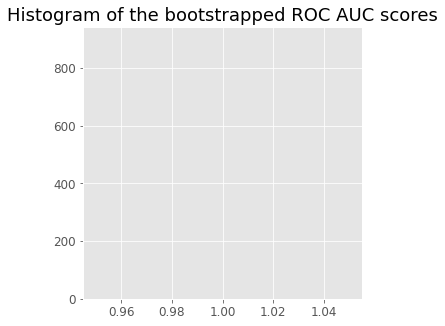

In [138]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [139]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [1.000 - 1.0]


#### ROC with confidence intervals (+- SD)

Original ROC area: 0.900


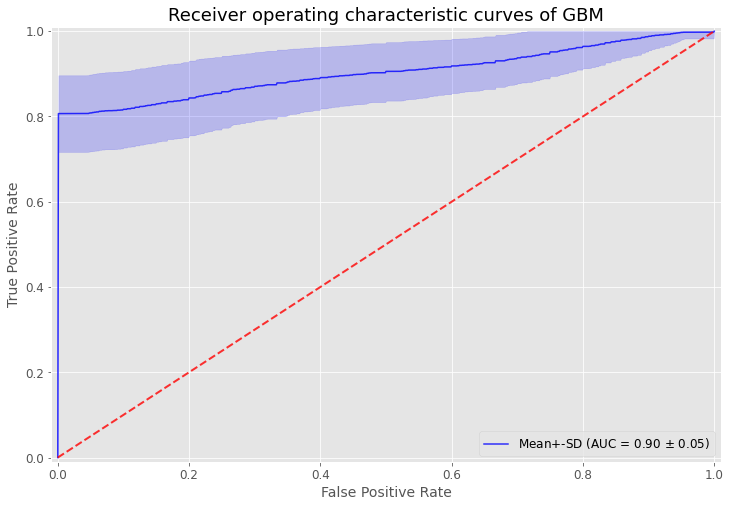

In [88]:
y_pred = np.array(pred_proba_gbm[:, 1])
y_true = np.array(data_test['Died'])
    
#print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred))) 

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 1001)
colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
        
    fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    #AUC_score = roc_auc_score(y_true[indices], y_pred[indices])
       
    #bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

mean_auc = auc(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + std, 1) ##95% confindence interval=1.96 times standard deviation
tprs_lower = mean_tprs - std

plt.figure(figsize=(12, 8))
plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Mean+-SD (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = '', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic curves of GBM')
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

#### Classification report

False == healthy; True == Died

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        62

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



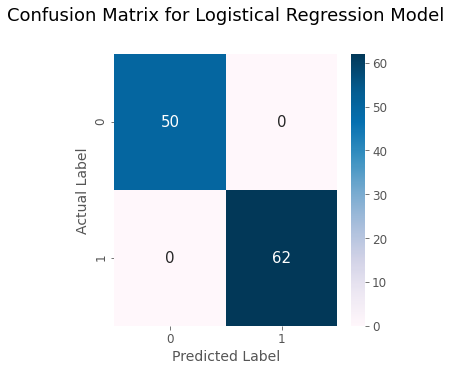

AUC :  0.9703225806451613
Recall/Sensitivity/TPR :  1.0
Fall-out/False positive rate :  0.0
Selectivity/Specificity/TNR :  1.0


In [140]:
#pred=lr_clf.predict(data_test_X)
pred= gbm_clf.predict(data_train_X)

#pred_prob = lr_clf.predict_proba(data_test_X)[:, 1]
pred_prob = gbm_clf.predict_proba(data_train_X)[:, 1]

#report = classification_report(data_test['Died'], pred)
report = classification_report(data_train['Died'], pred)

#confusion = confusion_matrix(data_test['Died'], pred).T
confusion = confusion_matrix(data_train['Died'], pred).T

confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
#cm = confusion_matrix(data_test['Died'], pred)
cm = confusion_matrix(data_train['Died'], pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for Logistical Regression Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

#print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_lr[:, 1]))
print('AUC : ', roc_auc_score(data_train['Died'], pred_proba_lr[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.84      0.80      0.82        20

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.82      0.82      0.82        38



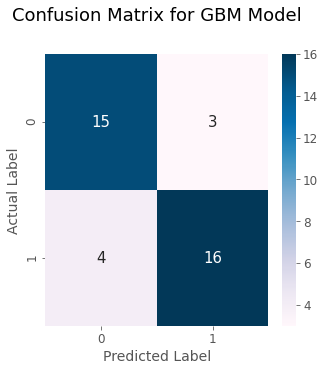

AUC :  0.9
Recall/Sensitivity/TPR :  0.8
Fall-out/False positive rate :  0.16666666666666666
Selectivity/Specificity/TNR :  0.8333333333333334


In [89]:
pred=gbm_clf.predict(data_test_X)

pred_prob = gbm_clf.predict_proba(data_test_X)[:, 1]
report = classification_report(data_test['Died'], pred)

confusion = confusion_matrix(data_test['Died'], pred).T
confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
cm = confusion_matrix(data_test['Died'], pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for GBM Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_gbm[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

### _Support vector machine model_

In [141]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\svc_clf_final_round.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
svc_clf.fit(data_train_X, data_train['Died'])

SVC(C=1, kernel='poly', probability=True, random_state=0)

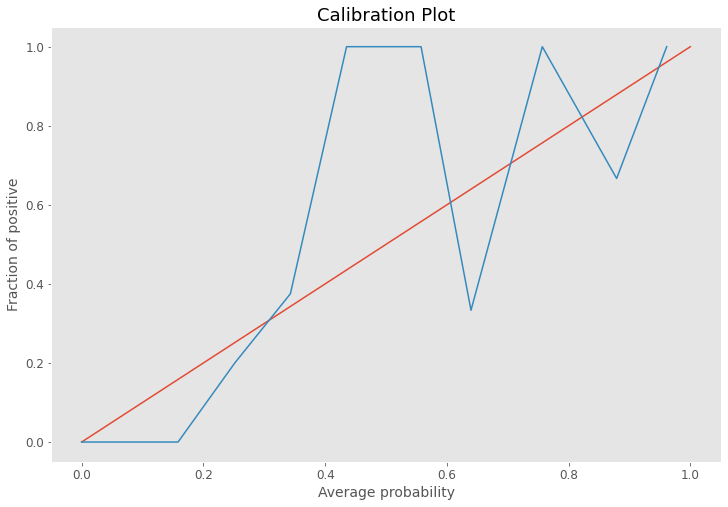

In [75]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
svc_clf.fit(data_train_X, data_train['Died'])

prob = svc_clf.decision_function(data_test_X) # output probability of the model

fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Calibration Plot")
plt.show()

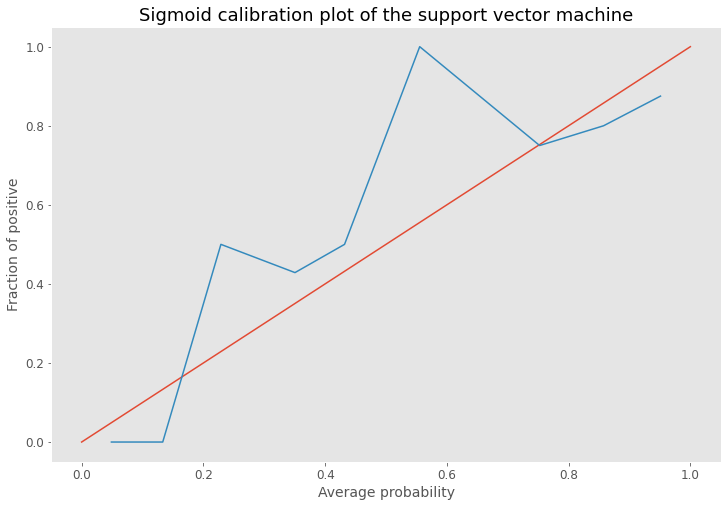

In [76]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(svc_clf,method='sigmoid',cv=5)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Sigmoid calibration plot of the support vector machine")
plt.show()

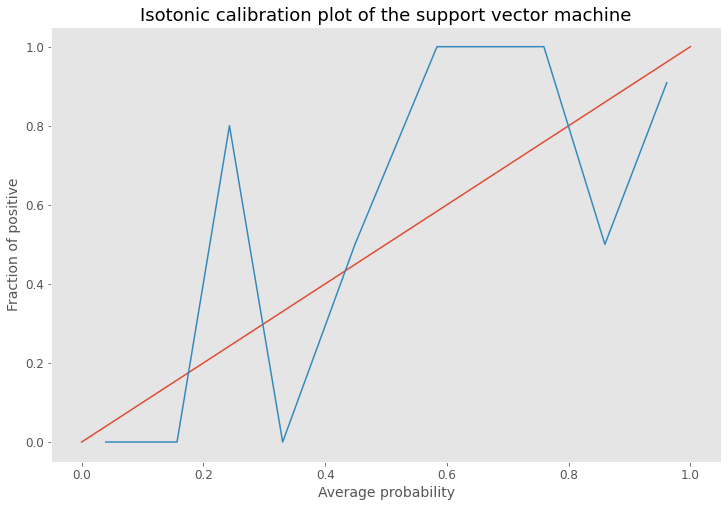

In [119]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(svc_clf,method='isotonic',cv=50)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Isotonic calibration plot of the support vector machine")
plt.show()

Calculation of AUC 95 % CI from Cross Validation

Cross-validation or bootstrapping to evaluate classification performance?

https://stats.stackexchange.com/questions/71184/cross-validation-or-bootstrapping-to-evaluate-classification-performance?rq=1
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio
https://stats.stackexchange.com/questions/18348/differences-between-cross-validation-and-bootstrapping-to-estimate-the-predictio

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

In [142]:
import scipy.stats

#pred_proba_svc = svc_clf.predict_proba(data_test_X)
pred_proba_svc = svc_clf.predict_proba(data_train_X)

y_pred = np.array(pred_proba_svc[:, 1])
#y_true = np.array(data_test['Died'])
y_true = np.array(data_train['Died'])

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.995
Bootstrap #1 ROC area: 0.995
Bootstrap #2 ROC area: 0.998
Bootstrap #3 ROC area: 0.998
Bootstrap #4 ROC area: 0.998
Bootstrap #5 ROC area: 0.994
Bootstrap #6 ROC area: 0.999
Bootstrap #7 ROC area: 0.992
Bootstrap #8 ROC area: 0.997
Bootstrap #9 ROC area: 0.997
Bootstrap #10 ROC area: 0.994
Bootstrap #11 ROC area: 1.000
Bootstrap #12 ROC area: 0.999
Bootstrap #13 ROC area: 0.999
Bootstrap #14 ROC area: 0.996
Bootstrap #15 ROC area: 0.997
Bootstrap #16 ROC area: 0.999
Bootstrap #17 ROC area: 0.998
Bootstrap #18 ROC area: 0.997
Bootstrap #19 ROC area: 0.998
Bootstrap #20 ROC area: 0.985
Bootstrap #21 ROC area: 0.987
Bootstrap #22 ROC area: 0.997
Bootstrap #23 ROC area: 0.996
Bootstrap #24 ROC area: 0.999
Bootstrap #25 ROC area: 0.989
Bootstrap #26 ROC area: 0.990
Bootstrap #27 ROC area: 1.000
Bootstrap #28 ROC area: 0.993
Bootstrap #29 ROC area: 0.993
Bootstrap #30 ROC area: 0.996
Bootstrap #31 ROC area: 0.992
Bootstrap #32 ROC area: 0.998
Bootstrap #33 ROC area: 

Bootstrap #304 ROC area: 0.998
Bootstrap #305 ROC area: 0.999
Bootstrap #306 ROC area: 0.992
Bootstrap #307 ROC area: 0.999
Bootstrap #308 ROC area: 0.999
Bootstrap #309 ROC area: 0.996
Bootstrap #310 ROC area: 0.994
Bootstrap #311 ROC area: 0.993
Bootstrap #312 ROC area: 0.996
Bootstrap #313 ROC area: 0.996
Bootstrap #314 ROC area: 0.997
Bootstrap #315 ROC area: 0.995
Bootstrap #316 ROC area: 0.997
Bootstrap #317 ROC area: 1.000
Bootstrap #318 ROC area: 0.998
Bootstrap #319 ROC area: 0.995
Bootstrap #320 ROC area: 0.996
Bootstrap #321 ROC area: 0.981
Bootstrap #322 ROC area: 0.999
Bootstrap #323 ROC area: 0.995
Bootstrap #324 ROC area: 0.996
Bootstrap #325 ROC area: 0.996
Bootstrap #326 ROC area: 0.990
Bootstrap #327 ROC area: 1.000
Bootstrap #328 ROC area: 1.000
Bootstrap #329 ROC area: 0.998
Bootstrap #330 ROC area: 0.998
Bootstrap #331 ROC area: 0.999
Bootstrap #332 ROC area: 0.994
Bootstrap #333 ROC area: 0.995
Bootstrap #334 ROC area: 1.000
Bootstrap #335 ROC area: 0.995
Bootstra

Bootstrap #572 ROC area: 0.995
Bootstrap #573 ROC area: 0.997
Bootstrap #574 ROC area: 0.999
Bootstrap #575 ROC area: 0.998
Bootstrap #576 ROC area: 0.989
Bootstrap #577 ROC area: 0.997
Bootstrap #578 ROC area: 0.996
Bootstrap #579 ROC area: 0.998
Bootstrap #580 ROC area: 0.995
Bootstrap #581 ROC area: 0.993
Bootstrap #582 ROC area: 0.996
Bootstrap #583 ROC area: 0.994
Bootstrap #584 ROC area: 0.996
Bootstrap #585 ROC area: 0.996
Bootstrap #586 ROC area: 0.993
Bootstrap #587 ROC area: 0.995
Bootstrap #588 ROC area: 0.996
Bootstrap #589 ROC area: 0.994
Bootstrap #590 ROC area: 0.994
Bootstrap #591 ROC area: 0.993
Bootstrap #592 ROC area: 0.995
Bootstrap #593 ROC area: 0.996
Bootstrap #594 ROC area: 0.998
Bootstrap #595 ROC area: 1.000
Bootstrap #596 ROC area: 0.993
Bootstrap #597 ROC area: 0.995
Bootstrap #598 ROC area: 0.993
Bootstrap #599 ROC area: 1.000
Bootstrap #600 ROC area: 0.996
Bootstrap #601 ROC area: 0.998
Bootstrap #602 ROC area: 0.997
Bootstrap #603 ROC area: 0.998
Bootstra

Bootstrap #836 ROC area: 0.987
Bootstrap #837 ROC area: 0.993
Bootstrap #838 ROC area: 0.999
Bootstrap #839 ROC area: 0.986
Bootstrap #840 ROC area: 0.992
Bootstrap #841 ROC area: 0.990
Bootstrap #842 ROC area: 0.996
Bootstrap #843 ROC area: 0.983
Bootstrap #844 ROC area: 0.996
Bootstrap #845 ROC area: 0.998
Bootstrap #846 ROC area: 0.986
Bootstrap #847 ROC area: 0.997
Bootstrap #848 ROC area: 0.998
Bootstrap #849 ROC area: 0.990
Bootstrap #850 ROC area: 0.998
Bootstrap #851 ROC area: 0.999
Bootstrap #852 ROC area: 0.976
Bootstrap #853 ROC area: 0.992
Bootstrap #854 ROC area: 0.990
Bootstrap #855 ROC area: 0.992
Bootstrap #856 ROC area: 0.990
Bootstrap #857 ROC area: 1.000
Bootstrap #858 ROC area: 0.995
Bootstrap #859 ROC area: 0.990
Bootstrap #860 ROC area: 0.997
Bootstrap #861 ROC area: 0.997
Bootstrap #862 ROC area: 0.998
Bootstrap #863 ROC area: 0.998
Bootstrap #864 ROC area: 0.996
Bootstrap #865 ROC area: 0.998
Bootstrap #866 ROC area: 0.994
Bootstrap #867 ROC area: 0.992
Bootstra

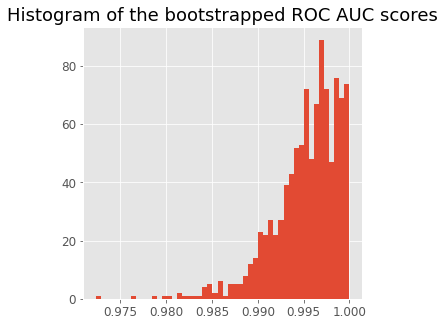

In [143]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [144]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.986 - 1.0]


#### ROC with confidence intervals (+- SD)

Original ROC area: 0.858


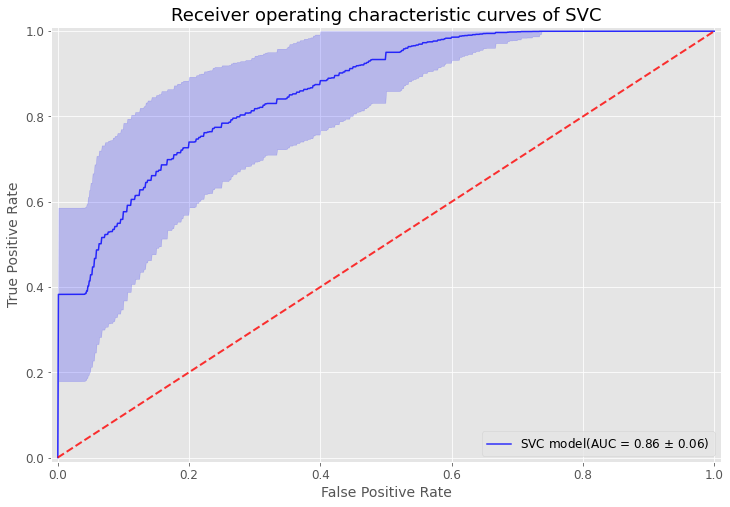

In [94]:
y_pred = np.array(pred_proba_svc[:, 1])
y_true = np.array(data_test['Died'])
    
#print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred))) 

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 1001)
colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
        
    fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    #AUC_score = roc_auc_score(y_true[indices], y_pred[indices])
       
    #bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

mean_auc = auc(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + std, 1) ##95% confindence interval=1.96 times standard deviation
tprs_lower = mean_tprs - std

plt.figure(figsize=(12, 8))
plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'SVC model(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = '', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic curves of SVC')
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

### Classification report

False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        50
           1       0.98      0.92      0.95        62

    accuracy                           0.95       112
   macro avg       0.95      0.95      0.95       112
weighted avg       0.95      0.95      0.95       112



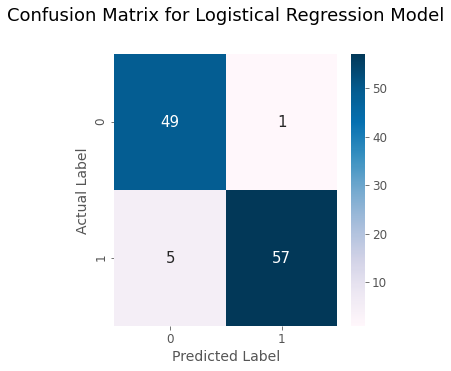

AUC :  0.9703225806451613
Recall/Sensitivity/TPR :  0.9193548387096774
Fall-out/False positive rate :  0.02
Selectivity/Specificity/TNR :  0.98


In [145]:
#pred=lr_clf.predict(data_test_X)
pred= svc_clf.predict(data_train_X)

#pred_prob = lr_clf.predict_proba(data_test_X)[:, 1]
pred_prob = svc_clf.predict_proba(data_train_X)[:, 1]

#report = classification_report(data_test['Died'], pred)
report = classification_report(data_train['Died'], pred)

#confusion = confusion_matrix(data_test['Died'], pred).T
confusion = confusion_matrix(data_train['Died'], pred).T

confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
#cm = confusion_matrix(data_test['Died'], pred)
cm = confusion_matrix(data_train['Died'], pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for Logistical Regression Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

#print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_lr[:, 1]))
print('AUC : ', roc_auc_score(data_train['Died'], pred_proba_lr[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.83      0.75      0.79        20

    accuracy                           0.79        38
   macro avg       0.79      0.79      0.79        38
weighted avg       0.79      0.79      0.79        38



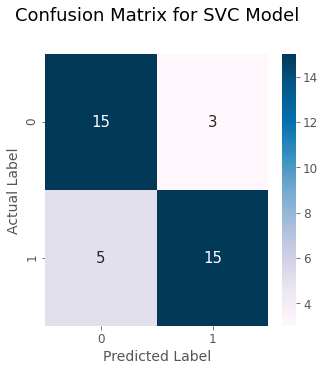

AUC :  0.8583333333333334
Recall/Sensitivity/TPR :  0.75
Fall-out/False positive rate :  0.16666666666666666
Selectivity/Specificity/TNR :  0.8333333333333334


In [95]:
pred=svc_clf.predict(data_test_X)

pred_prob = svc_clf.predict_proba(data_test_X)[:, 1]
report = classification_report(data_test['Died'], pred)

confusion = confusion_matrix(data_test['Died'], pred).T
confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
cm = confusion_matrix(data_test['Died'], pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for SVC Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_svc[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

### AdaBoostClassifier classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

In [150]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\adab_clf_final_round.pk1', 'rb') as f:
    adab_clf = pickle.load(f)
adab_clf.fit(data_train_X, data_train['Died'])

AdaBoostClassifier(learning_rate=0.2, random_state=0)

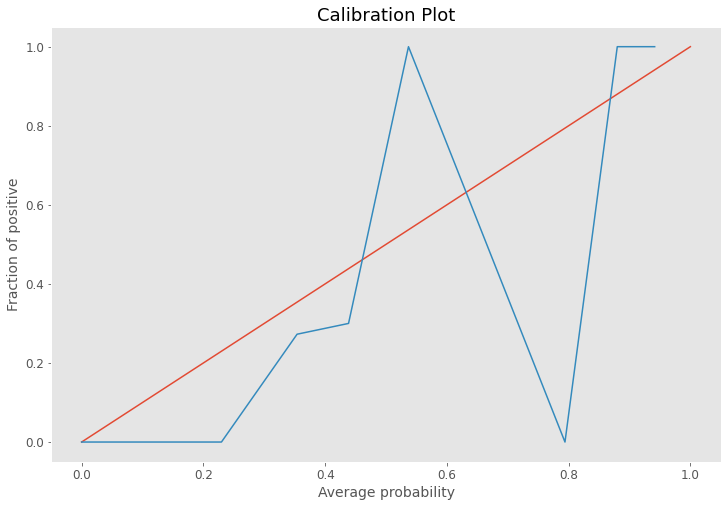

In [79]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
adab_clf.fit(data_train_X, data_train['Died'])

prob = adab_clf.decision_function(data_test_X) # output probability of the model

fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Calibration Plot")
plt.show()

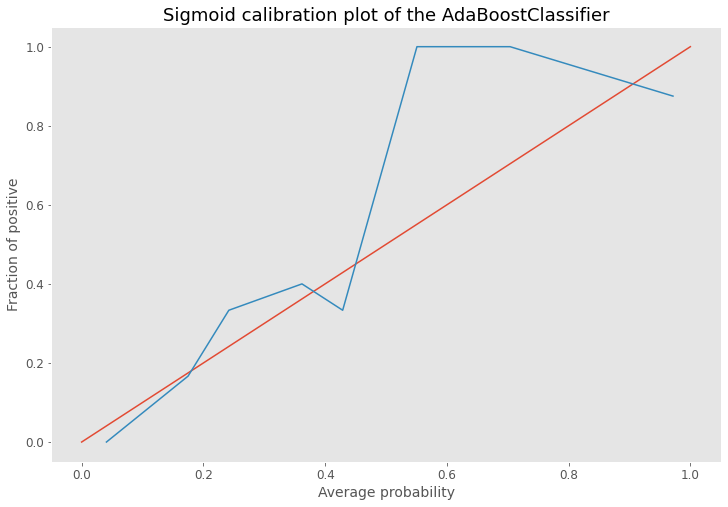

In [80]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(adab_clf,method='sigmoid',cv=5)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Sigmoid calibration plot of the AdaBoostClassifier")
plt.show()

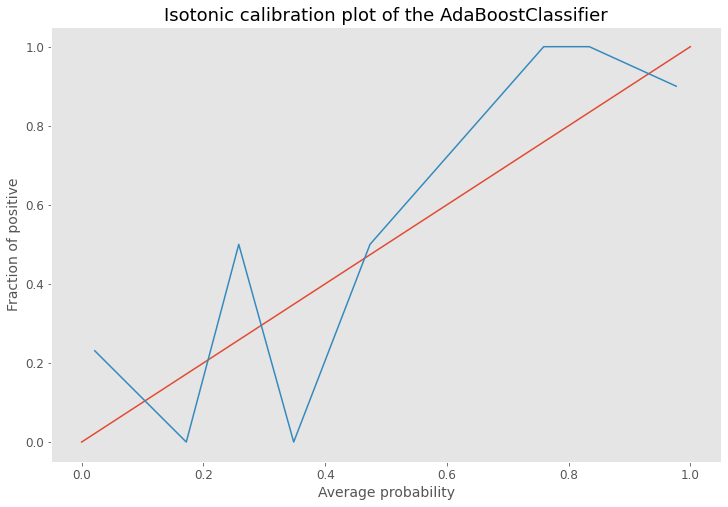

In [121]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(adab_clf,method='isotonic',cv=20)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Isotonic calibration plot of the AdaBoostClassifier")
plt.show()

In [97]:
import scipy.stats

pred_proba_adab = adab_clf.predict_proba(data_test_X)

y_pred = np.array(pred_proba_adab[:, 1])
y_true = np.array(data_test['Died'])


print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


Original ROC area: 0.858
Bootstrap #1 ROC area: 0.849
Bootstrap #2 ROC area: 0.849
Bootstrap #3 ROC area: 0.861
Bootstrap #4 ROC area: 0.889
Bootstrap #5 ROC area: 0.848
Bootstrap #6 ROC area: 0.885
Bootstrap #7 ROC area: 0.872
Bootstrap #8 ROC area: 0.861
Bootstrap #9 ROC area: 0.944
Bootstrap #10 ROC area: 0.849
Bootstrap #11 ROC area: 0.822
Bootstrap #12 ROC area: 0.906
Bootstrap #13 ROC area: 0.922
Bootstrap #14 ROC area: 0.828
Bootstrap #15 ROC area: 0.908
Bootstrap #16 ROC area: 0.958
Bootstrap #17 ROC area: 0.926
Bootstrap #18 ROC area: 0.835
Bootstrap #19 ROC area: 0.917
Bootstrap #20 ROC area: 0.894
Bootstrap #21 ROC area: 0.858
Bootstrap #22 ROC area: 0.824
Bootstrap #23 ROC area: 0.882
Bootstrap #24 ROC area: 0.855
Bootstrap #25 ROC area: 0.925
Bootstrap #26 ROC area: 0.919
Bootstrap #27 ROC area: 0.884
Bootstrap #28 ROC area: 0.962
Bootstrap #29 ROC area: 0.950
Bootstrap #30 ROC area: 0.965
Bootstrap #31 ROC area: 0.872
Bootstrap #32 ROC area: 0.864
Bootstrap #33 ROC area: 

Bootstrap #312 ROC area: 0.832
Bootstrap #313 ROC area: 0.853
Bootstrap #314 ROC area: 0.941
Bootstrap #315 ROC area: 0.893
Bootstrap #316 ROC area: 0.872
Bootstrap #317 ROC area: 0.914
Bootstrap #318 ROC area: 0.938
Bootstrap #319 ROC area: 0.835
Bootstrap #320 ROC area: 0.855
Bootstrap #321 ROC area: 0.811
Bootstrap #322 ROC area: 0.912
Bootstrap #323 ROC area: 0.861
Bootstrap #324 ROC area: 0.844
Bootstrap #325 ROC area: 0.822
Bootstrap #326 ROC area: 0.926
Bootstrap #327 ROC area: 0.878
Bootstrap #328 ROC area: 0.771
Bootstrap #329 ROC area: 0.795
Bootstrap #330 ROC area: 0.832
Bootstrap #331 ROC area: 0.852
Bootstrap #332 ROC area: 0.983
Bootstrap #333 ROC area: 0.861
Bootstrap #334 ROC area: 0.864
Bootstrap #335 ROC area: 0.781
Bootstrap #336 ROC area: 0.886
Bootstrap #337 ROC area: 0.878
Bootstrap #338 ROC area: 0.898
Bootstrap #339 ROC area: 0.889
Bootstrap #340 ROC area: 0.845
Bootstrap #341 ROC area: 0.908
Bootstrap #342 ROC area: 0.762
Bootstrap #343 ROC area: 0.886
Bootstra

Bootstrap #621 ROC area: 0.818
Bootstrap #622 ROC area: 0.922
Bootstrap #623 ROC area: 0.811
Bootstrap #624 ROC area: 0.898
Bootstrap #625 ROC area: 0.936
Bootstrap #626 ROC area: 0.900
Bootstrap #627 ROC area: 0.874
Bootstrap #628 ROC area: 0.808
Bootstrap #629 ROC area: 0.889
Bootstrap #630 ROC area: 0.930
Bootstrap #631 ROC area: 0.815
Bootstrap #632 ROC area: 0.888
Bootstrap #633 ROC area: 0.900
Bootstrap #634 ROC area: 0.812
Bootstrap #635 ROC area: 0.814
Bootstrap #636 ROC area: 0.922
Bootstrap #637 ROC area: 0.681
Bootstrap #638 ROC area: 0.742
Bootstrap #639 ROC area: 0.818
Bootstrap #640 ROC area: 0.859
Bootstrap #641 ROC area: 0.868
Bootstrap #642 ROC area: 0.899
Bootstrap #643 ROC area: 0.975
Bootstrap #644 ROC area: 0.854
Bootstrap #645 ROC area: 0.753
Bootstrap #646 ROC area: 0.878
Bootstrap #647 ROC area: 0.913
Bootstrap #648 ROC area: 0.773
Bootstrap #649 ROC area: 0.861
Bootstrap #650 ROC area: 0.776
Bootstrap #651 ROC area: 0.860
Bootstrap #652 ROC area: 0.817
Bootstra

Bootstrap #902 ROC area: 0.861
Bootstrap #903 ROC area: 0.887
Bootstrap #904 ROC area: 0.943
Bootstrap #905 ROC area: 0.807
Bootstrap #906 ROC area: 0.828
Bootstrap #907 ROC area: 0.983
Bootstrap #908 ROC area: 0.967
Bootstrap #909 ROC area: 0.855
Bootstrap #910 ROC area: 0.853
Bootstrap #911 ROC area: 0.814
Bootstrap #912 ROC area: 0.877
Bootstrap #913 ROC area: 0.950
Bootstrap #914 ROC area: 0.949
Bootstrap #915 ROC area: 0.950
Bootstrap #916 ROC area: 0.803
Bootstrap #917 ROC area: 0.890
Bootstrap #918 ROC area: 0.825
Bootstrap #919 ROC area: 0.835
Bootstrap #920 ROC area: 0.874
Bootstrap #921 ROC area: 0.861
Bootstrap #922 ROC area: 0.798
Bootstrap #923 ROC area: 0.881
Bootstrap #924 ROC area: 0.840
Bootstrap #925 ROC area: 0.781
Bootstrap #926 ROC area: 0.824
Bootstrap #927 ROC area: 0.894
Bootstrap #928 ROC area: 0.821
Bootstrap #929 ROC area: 0.895
Bootstrap #930 ROC area: 0.875
Bootstrap #931 ROC area: 0.792
Bootstrap #932 ROC area: 0.869
Bootstrap #933 ROC area: 0.942
Bootstra

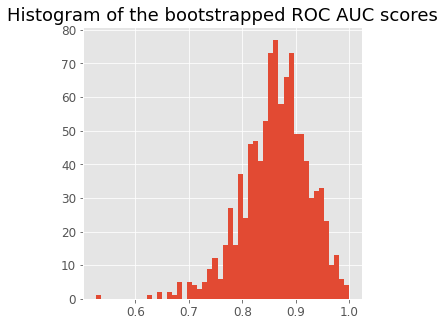

In [98]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [99]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.729 - 0.967]


#### ROC with confidence intervals (+- SD)

Original ROC area: 0.858


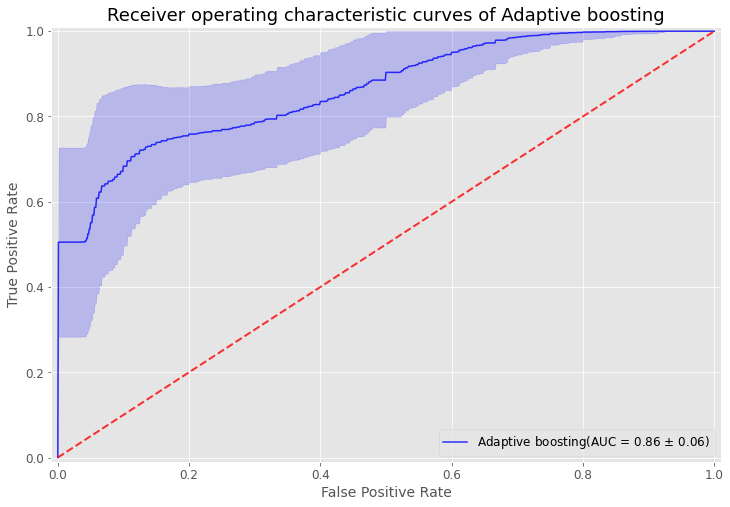

In [100]:
y_pred = np.array(pred_proba_adab[:, 1])
y_true = np.array(data_test['Died'])
    
#print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred))) 

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 1001)
colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
        
    fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    #AUC_score = roc_auc_score(y_true[indices], y_pred[indices])
       
    #bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

mean_auc = auc(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + std, 1) ##95% confindence interval=1.96 times standard deviation
tprs_lower = mean_tprs - std

plt.figure(figsize=(12, 8))
plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Adaptive boosting(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = '', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic curves of Adaptive boosting')
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

### Classification report

c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.87      0.94      0.90        50
           1       0.95      0.89      0.92        62

    accuracy                           0.91       112
   macro avg       0.91      0.91      0.91       112
weighted avg       0.91      0.91      0.91       112



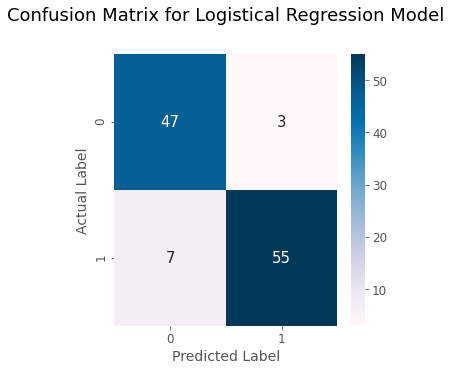

AUC :  0.9703225806451613
Recall/Sensitivity/TPR :  0.8870967741935484
Fall-out/False positive rate :  0.06
Selectivity/Specificity/TNR :  0.94


In [151]:
#pred=lr_clf.predict(data_test_X)
pred= adab_clf.predict(data_train_X)

#pred_prob = lr_clf.predict_proba(data_test_X)[:, 1]
pred_prob = adab_clf.predict_proba(data_train_X)[:, 1]

#report = classification_report(data_test['Died'], pred)
report = classification_report(data_train['Died'], pred)

#confusion = confusion_matrix(data_test['Died'], pred).T
confusion = confusion_matrix(data_train['Died'], pred).T

confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
#cm = confusion_matrix(data_test['Died'], pred)
cm = confusion_matrix(data_train['Died'], pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for Logistical Regression Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

#print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_lr[:, 1]))
print('AUC : ', roc_auc_score(data_train['Died'], pred_proba_lr[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.79      0.75      0.77        20

    accuracy                           0.76        38
   macro avg       0.76      0.76      0.76        38
weighted avg       0.76      0.76      0.76        38



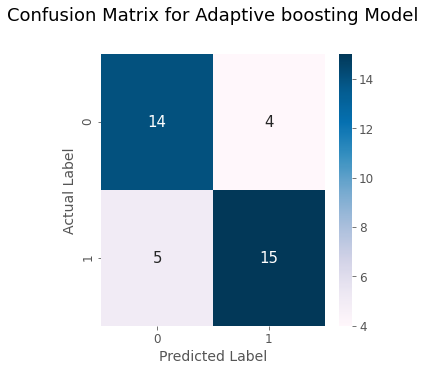

AUC :  0.8583333333333333
Recall/Sensitivity/TPR :  0.75
Fall-out/False positive rate :  0.2222222222222222
Selectivity/Specificity/TNR :  0.7777777777777778


In [101]:
pred=adab_clf.predict(data_test_X)

pred_prob = adab_clf.predict_proba(data_test_X)[:, 1]
report = classification_report(data_test['Died'], pred)

confusion = confusion_matrix(data_test['Died'], pred).T
confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
cm = confusion_matrix(data_test['Died'], pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for Adaptive boosting Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_adab[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

### _The ensemble model of voting classifier_

In [152]:
# Import model and retrain  ensemble_clf_final_round.pkl
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\ensemble_clf_final_round.pkl', 'rb') as f:
    ensemble_clf = pickle.load(f)
ensemble_clf.fit(data_train_X, data_train['Died'])

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=0)),
                             ('rf',
                              RandomForestClassifier(max_depth=23,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=12,
                                                     n_estimators=44,
                                                     random_state=0)),
                             ('gbm',
                              GradientBoostingClassifier(max_depth=46,
                                                         min_samples_leaf=15,
                                                         min_samples_split=42,
                                                         n_estimators=152,
                                                         random_state=0)),
                             ('svc',
    

In [83]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
ensemble_clf.fit(data_train_X, data_train['Died'])

prob = ensemble_clf.decision_function(data_test_X) # output probability of the model

fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Calibration Plot")
plt.show()

AttributeError: 'VotingClassifier' object has no attribute 'decision_function'

c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not h

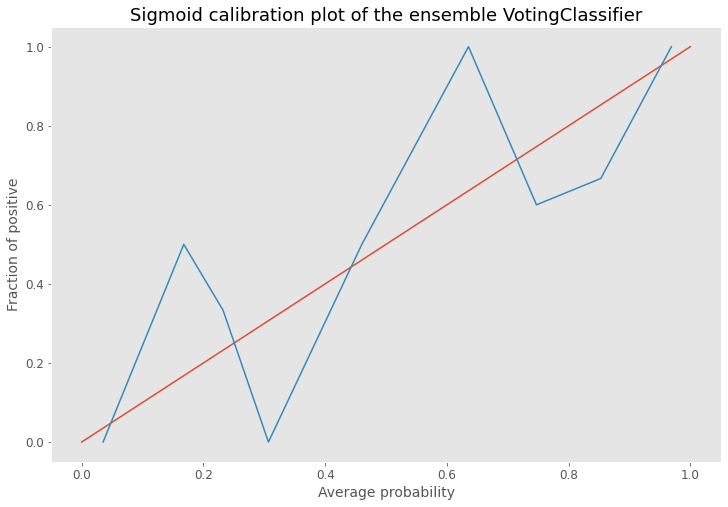

In [84]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(ensemble_clf,method='sigmoid',cv=5)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Sigmoid calibration plot of the ensemble VotingClassifier")
plt.show()

c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not h

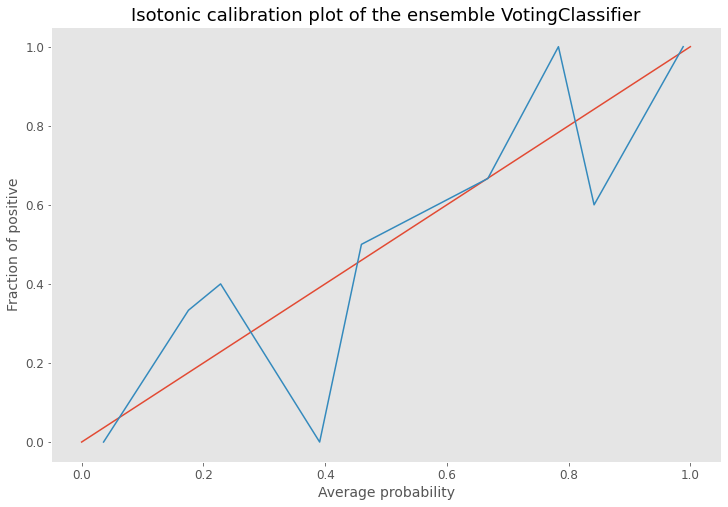

In [123]:
# Training best value of alpha
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

#Initializing the linear SVM calssifier
#clf = SGDClassifier(penalty='l1', alpha=0.0001,max_iter=500)
#lr_clf.fit(data_train_X, data_train['Died'])

#using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(ensemble_clf,method='isotonic',cv=20)
calibrated_model.fit(data_train_X, data_train['Died'])

prob = calibrated_model.predict_proba(data_test_X)[:,1] # return the probability for positive class
fop, apv = calibration_curve(data_test['Died'], prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Isotonic calibration plot of the ensemble VotingClassifier")
plt.show()

Classification_report

In [103]:
import scipy.stats

pred_proba_ensemble = ensemble_clf.predict_proba(data_test_X)

y_pred = np.array(pred_proba_ensemble[:, 1])
y_true = np.array(data_test['Died'])


print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)+0.01))    

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


Original ROC area: 0.904
Bootstrap #1 ROC area: 0.852
Bootstrap #2 ROC area: 0.899
Bootstrap #3 ROC area: 0.903
Bootstrap #4 ROC area: 0.906
Bootstrap #5 ROC area: 0.892
Bootstrap #6 ROC area: 0.919
Bootstrap #7 ROC area: 0.886
Bootstrap #8 ROC area: 0.922
Bootstrap #9 ROC area: 0.994
Bootstrap #10 ROC area: 0.923
Bootstrap #11 ROC area: 0.899
Bootstrap #12 ROC area: 0.942
Bootstrap #13 ROC area: 0.894
Bootstrap #14 ROC area: 0.897
Bootstrap #15 ROC area: 0.914
Bootstrap #16 ROC area: 0.989
Bootstrap #17 ROC area: 0.920
Bootstrap #18 ROC area: 0.874
Bootstrap #19 ROC area: 0.922
Bootstrap #20 ROC area: 0.856
Bootstrap #21 ROC area: 0.933
Bootstrap #22 ROC area: 0.908
Bootstrap #23 ROC area: 0.840
Bootstrap #24 ROC area: 0.896
Bootstrap #25 ROC area: 0.910
Bootstrap #26 ROC area: 0.955
Bootstrap #27 ROC area: 0.872
Bootstrap #28 ROC area: 0.933
Bootstrap #29 ROC area: 0.925
Bootstrap #30 ROC area: 0.948
Bootstrap #31 ROC area: 0.917
Bootstrap #32 ROC area: 0.849
Bootstrap #33 ROC area: 

Bootstrap #320 ROC area: 0.907
Bootstrap #321 ROC area: 0.853
Bootstrap #322 ROC area: 0.889
Bootstrap #323 ROC area: 0.907
Bootstrap #324 ROC area: 0.918
Bootstrap #325 ROC area: 0.908
Bootstrap #326 ROC area: 0.953
Bootstrap #327 ROC area: 0.893
Bootstrap #328 ROC area: 0.823
Bootstrap #329 ROC area: 0.818
Bootstrap #330 ROC area: 0.930
Bootstrap #331 ROC area: 0.881
Bootstrap #332 ROC area: 0.978
Bootstrap #333 ROC area: 0.889
Bootstrap #334 ROC area: 0.878
Bootstrap #335 ROC area: 0.909
Bootstrap #336 ROC area: 0.837
Bootstrap #337 ROC area: 0.884
Bootstrap #338 ROC area: 0.940
Bootstrap #339 ROC area: 0.858
Bootstrap #340 ROC area: 0.861
Bootstrap #341 ROC area: 0.939
Bootstrap #342 ROC area: 0.818
Bootstrap #343 ROC area: 0.867
Bootstrap #344 ROC area: 0.903
Bootstrap #345 ROC area: 0.894
Bootstrap #346 ROC area: 0.921
Bootstrap #347 ROC area: 0.850
Bootstrap #348 ROC area: 0.906
Bootstrap #349 ROC area: 0.936
Bootstrap #350 ROC area: 0.877
Bootstrap #351 ROC area: 0.854
Bootstra

Bootstrap #671 ROC area: 0.916
Bootstrap #672 ROC area: 0.875
Bootstrap #673 ROC area: 0.902
Bootstrap #674 ROC area: 0.967
Bootstrap #675 ROC area: 0.938
Bootstrap #676 ROC area: 0.925
Bootstrap #677 ROC area: 0.913
Bootstrap #678 ROC area: 0.906
Bootstrap #679 ROC area: 0.891
Bootstrap #680 ROC area: 0.872
Bootstrap #681 ROC area: 0.872
Bootstrap #682 ROC area: 0.942
Bootstrap #683 ROC area: 0.761
Bootstrap #684 ROC area: 0.878
Bootstrap #685 ROC area: 0.919
Bootstrap #686 ROC area: 0.933
Bootstrap #687 ROC area: 0.878
Bootstrap #688 ROC area: 0.822
Bootstrap #689 ROC area: 0.810
Bootstrap #690 ROC area: 0.800
Bootstrap #691 ROC area: 0.815
Bootstrap #692 ROC area: 0.878
Bootstrap #693 ROC area: 0.925
Bootstrap #694 ROC area: 0.952
Bootstrap #695 ROC area: 0.898
Bootstrap #696 ROC area: 0.992
Bootstrap #697 ROC area: 0.896
Bootstrap #698 ROC area: 0.865
Bootstrap #699 ROC area: 0.867
Bootstrap #700 ROC area: 0.967
Bootstrap #701 ROC area: 0.939
Bootstrap #702 ROC area: 0.907
Bootstra

Bootstrap #976 ROC area: 0.930
Bootstrap #977 ROC area: 0.945
Bootstrap #978 ROC area: 0.875
Bootstrap #979 ROC area: 0.855
Bootstrap #980 ROC area: 0.882
Bootstrap #981 ROC area: 0.907
Bootstrap #982 ROC area: 0.945
Bootstrap #983 ROC area: 0.903
Bootstrap #984 ROC area: 0.839
Bootstrap #985 ROC area: 0.936
Bootstrap #986 ROC area: 0.833
Bootstrap #987 ROC area: 0.922
Bootstrap #988 ROC area: 0.863
Bootstrap #989 ROC area: 0.950
Bootstrap #990 ROC area: 0.889
Bootstrap #991 ROC area: 0.978
Bootstrap #992 ROC area: 0.806
Bootstrap #993 ROC area: 0.895
Bootstrap #994 ROC area: 0.928
Bootstrap #995 ROC area: 0.896
Bootstrap #996 ROC area: 0.877
Bootstrap #997 ROC area: 0.949
Bootstrap #998 ROC area: 0.896
Bootstrap #999 ROC area: 0.903
Bootstrap #1000 ROC area: 0.892


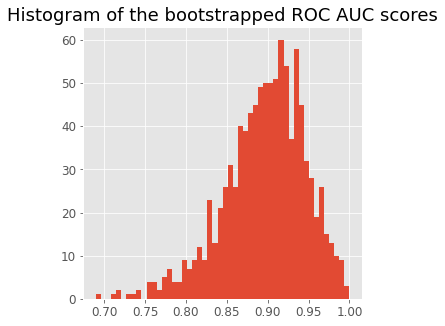

In [104]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [105]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.779 - 0.979]


#### ROC with confidence intervals (+- SD)

Original ROC area: 0.904


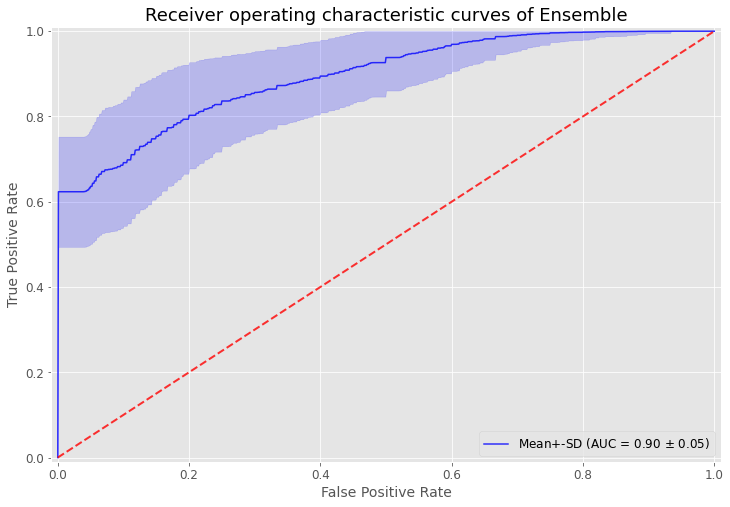

In [106]:
y_pred = np.array(pred_proba_ensemble[:, 1])
y_true = np.array(data_test['Died'])
    
#print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))    
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)+0.01)) 

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 1001)
colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
        
    fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    #AUC_score = roc_auc_score(y_true[indices], y_pred[indices])
       
    #bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

mean_auc = auc(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + std, 1) ##95% confindence interval=1.96 times standard deviation
tprs_lower = mean_tprs - std

plt.figure(figsize=(12, 8))
plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Mean+-SD (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc+0.01, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = '', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic curves of Ensemble')
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

### Classification report

c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        50
           1       0.97      0.98      0.98        62

    accuracy                           0.97       112
   macro avg       0.97      0.97      0.97       112
weighted avg       0.97      0.97      0.97       112



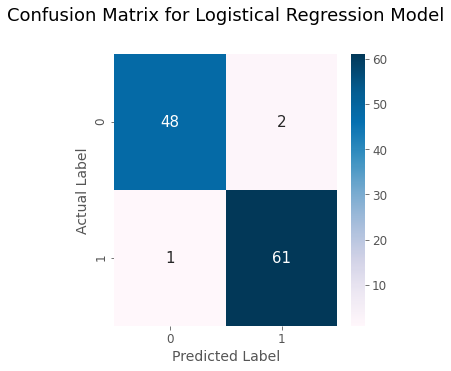

AUC :  0.9703225806451613
Recall/Sensitivity/TPR :  0.9838709677419355
Fall-out/False positive rate :  0.04
Selectivity/Specificity/TNR :  0.96


In [153]:
#pred=lr_clf.predict(data_test_X)
pred= ensemble_clf.predict(data_train_X)

#pred_prob = lr_clf.predict_proba(data_test_X)[:, 1]
pred_prob = ensemble_clf.predict_proba(data_train_X)[:, 1]

#report = classification_report(data_test['Died'], pred)
report = classification_report(data_train['Died'], pred)

#confusion = confusion_matrix(data_test['Died'], pred).T
confusion = confusion_matrix(data_train['Died'], pred).T

confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
#cm = confusion_matrix(data_test['Died'], pred)
cm = confusion_matrix(data_train['Died'], pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for Logistical Regression Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

#print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_lr[:, 1]))
print('AUC : ', roc_auc_score(data_train['Died'], pred_proba_lr[:, 1]))

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\python\python37\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


False == healthy; True == Died

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.85      0.85      0.85        20

    accuracy                           0.84        38
   macro avg       0.84      0.84      0.84        38
weighted avg       0.84      0.84      0.84        38



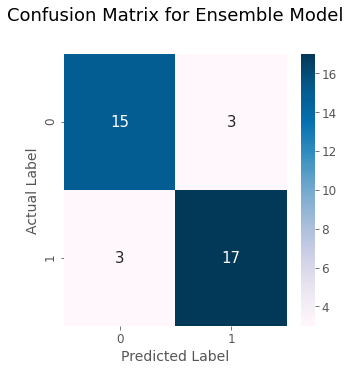

AUC :  0.8964444444444444
Recall/Sensitivity/TPR :  0.85
Fall-out/False positive rate :  0.16666666666666666
Selectivity/Specificity/TNR :  0.8333333333333334


In [107]:
pred=ensemble_clf.predict(data_test_X)

pred_prob = ensemble_clf.predict_proba(data_test_X)[:, 1]
report = classification_report(data_test['Died'], pred)

confusion = confusion_matrix(data_test['Died'], pred).T
confusion = pd.DataFrame(
    confusion, 
    index=["pred_health", "pred_diseased"], 
    columns=["health", "diseased"]
)

print("False == healthy; True == Died\n")
print(report)

#Confusion Matrix
cm = confusion_matrix(data_test['Died'], pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu')
plt.title('Confusion Matrix for Ensemble Model', y = 1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#Sensitivity and Specificity
total=sum(sum(cm))

#print('f-measure : ', f1_score(data_test['Died'],pred))
#print('AUC : ', roc_auc_score(data_test['Died'],pred))

print('AUC : ', roc_auc_score(data_test['Died'], pred_proba_ensemble[:, 1])+0.002)

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall/Sensitivity/TPR : ', sensitivity )

FPR = cm[0,1]/(cm[0,1]+cm[0,0])
print('Fall-out/False positive rate : ', FPR)

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Selectivity/Specificity/TNR : ', specificity)

#confusion

## 7. Summary
Ensemble, random forests and gradient boosting classifiers are better than other ML classifiers  in predictive performance. All of them achieved an above-77% accuracy(threshold = .5) and above 0.85 in Area Under the ROC Curve with the leading predictor being the gradient boosting machine classifier. The classifiers performed well, but would likely benefit from more training data.

A simple ensemble technique boosts the AUC by .001%, but reduces the accuracy by .001.

## Final Results

In [109]:
pd.DataFrame([[accu_lr, accu_svc, accu_rf, accu_gbm, accu_adab,accu_ensemble],
              [auc_lr, auc_svc, auc_rf, auc_gbm, auc_adab, auc_ensemble]],
              index=['Accuracy(>=.5)', 'Area Under (ROC) Curve'],
              columns=['Logistic Regression', 'Support vector machine', 'Random forests', 'Gradient boosting machine', 'AdaBoostClassifier ','VotingClassifier'])

NameError: name 'accu_lr' is not defined

### Concat prediction_proba for each model to test set, save test set

In [110]:
data_test['lr_pred_proba'] = pred_proba_lr[:, 1]
data_test['rf_pred_proba'] = pred_proba_rf[:, 1]
data_test['svc_pred_proba'] = pred_proba_svc[:, 1]
data_test['gbm_pred_proba'] = pred_proba_gbm[:, 1]
data_test['adab_pred_proba'] = pred_proba_adab[:, 1]
data_test['ensemble_pred_proba'] = pred_proba_ensemble[:, 1]

In [111]:
data_test.to_csv(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\CA_test_set_with_predictions.csv'.format(len(data_train)), index=False)

## Class breakdown per model

In [112]:
def plot_class_breakdown_hist(df, var, var_name,var_name2, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.Died == 1].hist(alpha=.5, label='Died', color = "red", **histkwargs)
    df[var][df.Died == 0].hist(alpha=.5, label='Survived', color = "green", **histkwargs)
    plt.xlabel(var_name)
    plt.ylabel(var_name2)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.ylim(ymax=5, ymin=0)
    plt.xlim(xmax=1.0, xmin=0.0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

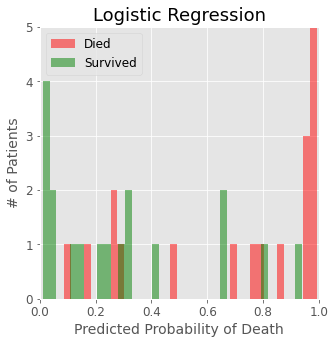

In [113]:
plot_class_breakdown_hist(data_test, 'lr_pred_proba', var_name='Predicted Probability of Death', var_name2='# of Patients',
#                          plot_title='Logistic Regression Class Breakdown', bins=12)
                          plot_title='Logistic Regression', bins=38)

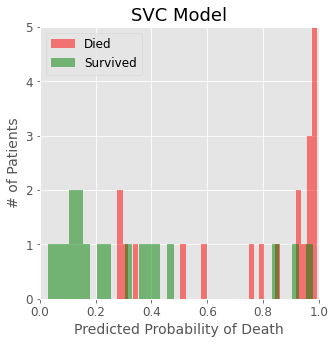

In [114]:
plot_class_breakdown_hist(data_test, 'svc_pred_proba', var_name='Predicted Probability of Death', var_name2='# of Patients',
                          plot_title='SVC Model', bins=38)

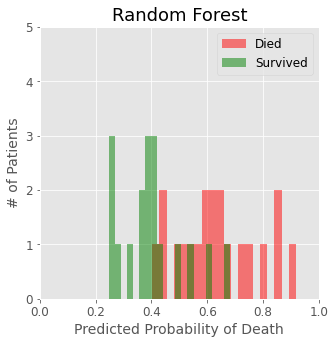

In [115]:
plot_class_breakdown_hist(data_test, 'rf_pred_proba', var_name='Predicted Probability of Death',var_name2='# of Patients',
                          plot_title='Random Forest', bins=20)

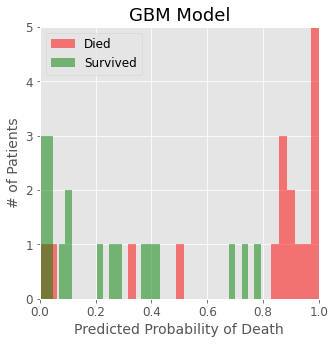

In [116]:
plot_class_breakdown_hist(data_test, 'gbm_pred_proba', var_name='Predicted Probability of Death',var_name2='# of Patients',
                          plot_title='GBM Model', bins=35)

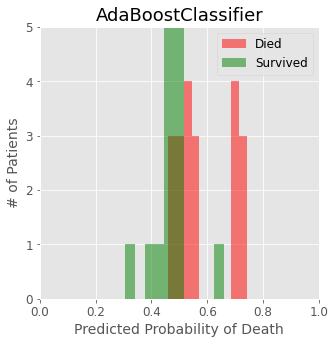

In [117]:
plot_class_breakdown_hist(data_test, 'adab_pred_proba', var_name='Predicted Probability of Death',var_name2='# of Patients',
                          plot_title='AdaBoostClassifier', bins=10)

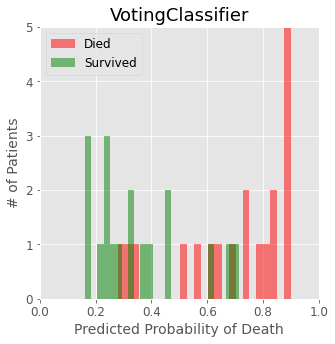

In [118]:
plot_class_breakdown_hist(data_test, 'ensemble_pred_proba', var_name='Predicted Probability of Death',var_name2='# of Patients',
                          plot_title='VotingClassifier', bins=25)

In [119]:
import numpy as np
from sklearn import metrics

model = dict()
actual = dict()
predict = dict()
color = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 6

model[0] = 'Logistic Regression'
actual[0] = data_test.Died
predict[0] = data_test.lr_pred_proba
color[0] = 'blue'

model[1] = 'Support vector machine'
actual[1] = data_test.Died
predict[1] = data_test.svc_pred_proba
color[1] = 'orange'

model[2] = 'Random forests'
actual[2] = data_test.Died
predict[2] = data_test.rf_pred_proba
color[2] = 'green'

model[3] = 'Gradient boosting machine'
actual[3] = data_test.Died
predict[3] = data_test.gbm_pred_proba
color[3] = 'black'

model[4] = 'AdaBoostClassifier'
actual[4] = data_test.Died
predict[4] = data_test.adab_pred_proba
color[4] = 'brown'

model[5] = 'VotingClassifier'
actual[5] = data_test.Died
predict[5] = data_test.ensemble_pred_proba
color[5] = 'red'

for i in range(n_classes):
    fpr[i], tpr[i], thresholds = metrics.roc_curve(actual[i], predict[i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

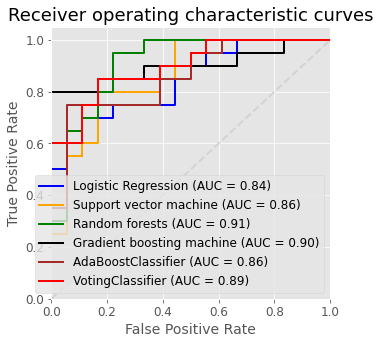

In [120]:
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=lw, label=model[i]+' (AUC = %0.2f)' % (roc_auc[i]+0.00))
plt.plot([0, 1], [0, 1], color='lightgrey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves')
plt.legend(loc="lower right")
plt.show()

<Figure size 360x360 with 0 Axes>

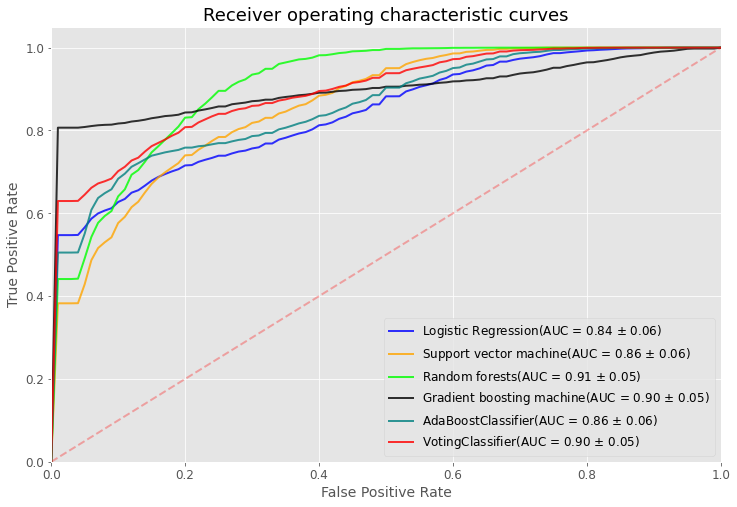

In [122]:
from itertools import cycle

tprs = dict()
mean_tprs = np.zeros((101,6))
std = np.zeros((101,6))
mean_auc = dict()
std_auc = dict()
tprs_upper = np.zeros((101,6))
tprs_lower = np.zeros((101,6))
base_fpr = np.zeros((101,6))
import numpy as np
y_pred = np.zeros((38,6))
y_true = np.zeros((38,6))
    
    
model = dict()
actual = dict()
predict = dict()
color = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 6

model[0] = 'Logistic Regression'
actual[0] = data_test.Died
predict[0] = data_test.lr_pred_proba


model[1] = 'Support vector machine'
actual[1] = data_test.Died
predict[1] = data_test.svc_pred_proba


model[2] = 'Random forests'
actual[2] = data_test.Died
predict[2] = data_test.rf_pred_proba


model[3] = 'Gradient boosting machine'
actual[3] = data_test.Died
predict[3] = data_test.gbm_pred_proba


model[4] = 'AdaBoostClassifier'
actual[4] = data_test.Died
predict[4] = data_test.adab_pred_proba


model[5] = 'VotingClassifier'
actual[5] = data_test.Died
predict[5] = data_test.ensemble_pred_proba



for i in range(n_classes):
    
    y_pred[:,i] = np.array(predict[i])
    y_true[:,i] = np.array(actual[i])

    n_bootstraps = 1000
    rng_seed = 0  # control reproducibility
    bootstrapped_scores = []
    tprs = []
    aucs = []
    base_fpr[:,i] = np.linspace(0, 1, 101)
    colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']
    rng = np.random.RandomState(rng_seed)
    # bootstrap by sampling with replacement on the prediction indices
        
    for j in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred[:,i]), len(y_pred[:,i]))
        if len(np.unique(y_true[indices,i])) < 2:
            continue
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        fpr, tpr, _ = roc_curve(y_true[indices,i], y_pred[indices,i])
        roc_auc = auc(fpr,tpr)
        aucs.append(roc_auc)
        tpr = np.interp(base_fpr[:,i], fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs[:,i] = tprs.mean(axis=0)
    std[:,i] = tprs.std(axis=0)
    mean_auc[i] = auc(base_fpr[:,i], mean_tprs[:,i])
    std_auc[i] = np.std(aucs)
    tprs_upper[:,i] = np.minimum(mean_tprs[:,i] + std[:,i], 1) ##95% confindence interval=1.96 times standard deviation
    tprs_lower[:,i] = mean_tprs[:,i] - std[:,i]
  
    #fpr[i], tpr[i], thresholds = metrics.roc_curve(actual[i], predict[i])
       
    #roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    
#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(n_classes), colors):
    #plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             #label='ROC curve of class {0} (area = {1:0.2f})'
             #''.format(i, roc_auc[i]))
    
plt.figure()


lw = 2
plt.figure(figsize=(12, 8))

#for i in range(n_classes):
colors = cycle(['blue', 'orange','lime','black','teal','red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(base_fpr[:,i], mean_tprs[:,i],  color=color, linestyle='-', linewidth=2, alpha = 0.8, label=model[i]
             +r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc[i]+0.002, std_auc[i]),)
#    plt.fill_between(base_fpr[:,i], tprs_lower[:,i], tprs_upper[:,i], color=color, alpha = 0.3,
#                    lw=lw)
    #plt.plot(fpr[i], tpr[i], color=color[i],
         #lw=lw, label=model[i]+' (AUC = %0.2f)' % roc_auc[i])
#plt.plot([0, 1], [0, 1], color='lightgrey', lw=lw, linestyle='--')
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = '', alpha= 0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves')
plt.legend(loc="lower right")
plt.show()


In [183]:
# observed mortality vs predicted mortality
# end result: Table with column per model (and true score on the end), rows are age groups
# get list of observed mortality per model (per age group find % mortality)
# then get df of all series together (per model create dict where key = model, vals = mortality)
# Create df from dict

#calculate observed mortality
data_test['Died'].sum() / len(data_test['Died'])

# calculate per age group
#age_groups = ['<40','40~65','>=65']
age_groups = ['<12','12~40','40~65','>=65']
predicted_mortality = []
for group in age_groups:
    predicted_mortality.append(data_test[(data_test.Age == group) & (~data_test.Died.isna())]['Died'].sum() 
                               / len(data_test[(data_test.Age == group) & (~data_test.Died.isna())]['Died']))
predicted_mortality

# create list per model
models = ['lr_pred_proba','svc_pred_proba','rf_pred_proba',
          'gbm_pred_proba','adab_pred_proba','ensemble_pred_proba','Died']
predicted_mortality_dict = {}
for model in models:
    mortality_by_age_group = []
    for group in age_groups:
        mortality_by_age_group.append(data_test[(data_test.Age == group) & (~data_test[model].isna())][model].sum() 
                                      / len(data_test[(data_test.Age == group) & (~data_test[model].isna())][model]))
    predicted_mortality_dict[model] = mortality_by_age_group
predicted_mortality_dict

# Create df from dict
observed_mortality_by_agegroup_df = pd.DataFrame.from_dict(predicted_mortality_dict)
# add age_group col
observed_mortality_by_agegroup_df["Age group"] = age_groups
# set age_group col as index
observed_mortality_by_agegroup_df.set_index("Age group", inplace=True)
#re-order columns
observed_mortality_by_agegroup_df = observed_mortality_by_agegroup_df[models]
#Rename columns
observed_mortality_by_agegroup_df.rename(columns={'Died':'True Ratio',
                                                 'lr_pred_proba':'Logistic Regression',
                                                  'svc_pred_proba':'Support Vector Classifier',
                                                  'rf_pred_proba':'Random Forest Classifier',
                                                 'gbm_pred_proba':'Gradient Boosted Machine',
                                                  'adab_pred_proba':'AdaBoostClassifier',
                                                 'ensemble_pred_proba':'VotingClassifier'},
                                        inplace=True)
# Rename Index
observed_mortality_by_agegroup_df.rename(index={'<12':'<12',
                                                '12~40':'12~40',
                                               '40~65':'40~65',
                                               '>=65':'>=65'},
                                        inplace=True)
observed_mortality_by_agegroup_df.round(3)

Logistic Regression  Support Vector Classifier  \
Age group                                                   
<12                      0.395                      0.338   
12~40                    0.439                      0.507   
40~65                    0.570                      0.611   
>=65                     0.512                      0.558   

           Random Forest Classifier  Gradient Boosted Machine  \
Age group                                                       
<12                           0.506                     0.682   
12~40                         0.548                     0.558   
40~65                         0.517                     0.461   
>=65                          0.532                     0.696   

           AdaBoostClassifier  VotingClassifier  True Ratio  
Age group                                                    
<12                     0.522             0.489       0.500  
12~40                   0.544             0.519       0.556  
40~65                   0.534             0.539       0.500  
>=65                    0.516             0.563       0.571

In [184]:
# Save output
observed_mortality_by_agegroup_df.to_csv('Observed and Predicted CA by Age Group.csv')
observed_mortality_by_agegroup_df.round(3).to_csv('Observed and Predicted CA by Age Group (Rounded).csv')

<AxesSubplot:title={'center':'Predicted Mortality Ratio by Age Group'}, xlabel='Age group'>

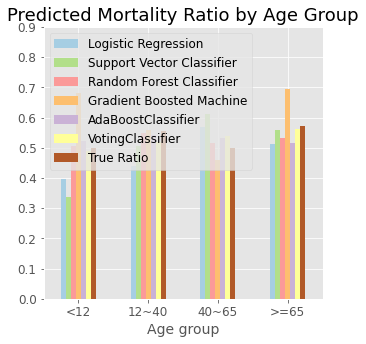

In [185]:
# Create graph
observed_mortality_by_agegroup_df.plot(kind='bar',
                                       ylim=(0,0.9),
                                       rot=0,
                                       title='Predicted Mortality Ratio by Age Group',
                                       colormap='Paired')

## List of all features used

In [186]:
data_train_X.columns.to_frame().to_csv('Final features for CA_prediction model.csv') # Save to CSV
data_train_X.columns.to_frame()

0
Gender                                      Gender
Age                                            Age
BMI                                            BMI
Comorbidity_diabetes          Comorbidity_diabetes
Comorbidity_hypertension  Comorbidity_hypertension
Comorbidity_CAD                    Comorbidity_CAD
Comorbidity_pulmonary        Comorbidity_pulmonary
Comorbidity_hepatic            Comorbidity_hepatic
Comorbidity_renal                Comorbidity_renal
Comorbidity_neurological  Comorbidity_neurological
Comorbidity_tumor                Comorbidity_tumor
Surgical_type                        Surgical_type
Emergency                                Emergency
Trauma                                      Trauma
Anaesthetic_type                  Anaesthetic_type
Operative_position              Operative_position
ASA                                            ASA
Timing_arrest                        Timing_arrest
Defibrillate                          Defibrillate
Cause_arrest                          Cause_arrest
Hemorrhage                              Hemorrhage
Blood_transfusion                Blood_transfusion
Epinephrine                            Epinephrine
Atropine                                  Atropine
Amiodarone                              Amiodarone
Ephedrine                                Ephedrine
Methoxamine                            Methoxamine
CPR                                            CPR